# Entrenamiento de modelos de aprendizaje con el dataset Polyvore

**Autor:** Roberto Araya Day

**Fecha de inicio:** 16/11/2022

## 1. Preparación de datos

- El archivo *type_aware_polyvore_outfits.py* es el script de **Learning Type Aware Embeddings for Fashion Compatibility** para cargar el dataset de Polyvore y crear ejemplos. Se define un **TripletImageLoader** con una serie de transformaciones para las imágenes. Este archivo retorna *Triplets* de imágenes postivas y negativas. Modificamos este archivo en la forma de **DoubletImageLoader** para retornar pares de imágenes. Revisar el archivo. 
- El archivo *similarity_conditions_triplet_image_loader.py* es el script de **Learning similarity Conditions** para cargar triplets de datos de Polyvore. Revisar.

- Se dividen en los archivos:
    - ***fashion_compatibility_prediction.txt***: En ***fashion_compatibility_prediction_val.txt*** y ***fashion_compatibility_prediction_test.txt*** para las métricas de validación y testeo. Puesto que el archivo contiene **7076** columnas, se ponen **3538** ejemplos en cada archivo.
    - ***fill_in_blank_test.txt***.
---

Los modelos de recomendación están conformados por la siguiente estructura:
1. **DoubletImageLoader**: Carga las imágenes, con sus metadatos, y se crean los ejemplos de pares de prendas positivos. Es decir, prendas compatibles. Esta basado en los dataloader de ambas investigaciones señaladas anteriormente.
    - Un DataLoader es una estructura que combina un dataset y un sampler, y provee un iterador sobre el dataset.


2. **DoubletNet**: Genera los embeddings y calcula la pérdida y distancia entre los vectores obtenidos de los ejemplos positivos. No se necesita para este caso, puesto que el **Modelo General** lo hace por si solo. No necesita obtener el loss o accuracy de los pares de imágenes.


3. **Modelo General**: Variante del modelo BYOL que recibe dos imágenes de entrada.

In [18]:
import sys
import os
sys.path.append('/home/raraya/miniconda3/envs/fashion_model/lib/python3.10/site-packages')

In [19]:
# path to important folders
polyvore_dataset = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'fashion_proj', 'polyvore_data')
polyvore_images = os.path.join(polyvore_dataset, 'images')
polyvore_info = os.path.join(polyvore_dataset, 'polyvore-info')

polyvore_train = os.path.join(polyvore_info, 'train_no_dup')
polyvore_val = os.path.join(polyvore_info, 'valid_no_dup')
polyvore_test = os.path.join(polyvore_info, 'test_no_dup')

In [20]:
from itertools import permutations
import itertools

data = {('bags', 'shoes'): 0, ('bags', 'jewellery'): 1, ('bags', 'tops'): 2, ('bags', 'bottoms'): 3,
    ('shoes', 'jewellery'): 4, ('shoes', 'tops'): 5, ('shoes', 'bottoms'): 6,
    ('jewellery', 'tops'): 7, ('jewellery', 'bottoms'): 8, ('tops', 'bottoms'): 9,
    ('bags', 'sunglasses'): 10, ('bags', 'all-body'): 11, ('shoes', 'sunglasses'): 12,
    ('shoes', 'all-body'): 13, ('jewellery', 'sunglasses'): 14, ('jewellery', 'all-body'): 15,
    ('sunglasses', 'all-body'): 16, ('shoes', 'accessories'): 17, ('jewellery', 'accessories'): 18,
    ('tops', 'accessories'): 19, ('tops', 'sunglasses'): 20, ('accessories', 'sunglasses'): 21,
    ('accessories', 'bottoms'): 22, ('sunglasses', 'bottoms'): 23, ('all-body', 'all-body'): 24,
    ('bags', 'scarves'): 25, ('bags', 'outerwear'): 26, ('shoes', 'scarves'): 27,
    ('shoes', 'outerwear'): 28, ('jewellery', 'jewellery'): 29, ('jewellery', 'scarves'): 30,
    ('jewellery', 'outerwear'): 31, ('all-body', 'scarves'): 32, ('all-body', 'outerwear'): 33,
    ('scarves', 'outerwear'): 34, ('bags', 'accessories'): 35, ('accessories', 'all-body'): 36,
    ('bags', 'hats'): 37, ('shoes', 'hats'): 38, ('jewellery', 'hats'): 39, ('hats', 'all-body'): 40,
    ('hats', 'outerwear'): 41, ('tops', 'outerwear'): 42, ('bottoms', 'outerwear'): 43,
    ('tops', 'scarves'): 44, ('accessories', 'scarves'): 45, ('accessories', 'outerwear'): 46,
    ('bottoms', 'scarves'): 47, ('tops', 'all-body'): 48, ('hats', 'tops'): 49,
    ('hats', 'sunglasses'): 50, ('hats', 'bottoms'): 51, ('sunglasses', 'outerwear'): 52,
    ('bags', 'bags'): 53, ('shoes', 'shoes'): 54, ('hats', 'accessories'): 55,
    ('scarves', 'scarves'): 56, ('tops', 'tops'): 57, ('all-body', 'bottoms'): 58,
    ('sunglasses', 'scarves'): 59, ('hats', 'scarves'): 60, ('accessories', 'accessories'): 61,
    ('bottoms', 'bottoms'): 62, ('outerwear', 'outerwear'): 63, ('hats', 'hats'): 64,  ('sunglasses', 'sunglasses'): 65}

def get_unique_items(dictionary):
    unique_items = []

    for pair in dictionary:
        item1, item2 = pair
        if item1 not in unique_items: unique_items.append(item1)
        if item2 not in unique_items: unique_items.append(item2)

    return unique_items

unique_items = list(get_unique_items(data))
#print(len(unique_items), unique_items)

pairs_items = list([p for p in itertools.product(unique_items, repeat=2)])
#print(len(pairs_items), pairs_items)

typespaces_csa = dict(zip(pairs_items, range(len(pairs_items))))

In [21]:
unique_items

['bags',
 'shoes',
 'jewellery',
 'tops',
 'bottoms',
 'sunglasses',
 'all-body',
 'accessories',
 'scarves',
 'outerwear',
 'hats']

## 2. Instalación de los modelos de aprendizaje
### 2.1 Instalación del modelo BYOL

   Se instala la variante del modelo BYOL del trabajo de *Javier Morales Rodriguez* del repositorio *bimodal-byol-shoes*:
- https://github.com/javier-op/bimodal-byol-shoes.

In [22]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
%reload_ext autoreload

In [24]:
%autoreload 2

In [25]:
os.path.isfile('runs/new_model_type_aware/checkpoint.pth.tar')

False

In [27]:
from __future__ import print_function
import argparse
import os
import sys
import shutil
import json
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

import Resnet_18
from polyvore_outfits_csa import TripletImageLoader
from tripletnet import Tripletnet
from tripletnet_original import Tripletnet as tripletnet_org
from ConditionalSimNet_adapt import ConditionalSimNet, ConditionalSimNet2, ConditionalSimNetNew, ConditionalSimNetRobert, ConditionalSimNetRobertSum
import sys
from sentence_transformers import SentenceTransformer


test_arg = False
use_fc_arg = False
learned_arg = True
prein_arg = True
epochs_args = 20
batch_size_args = 96
learning_rate_args = 5e-5
num_conditions = 5
margin_arg = 0.3
lr_scheduler_arg = 0.9

# names of model
name_arg = 'csa_adapt_grayscale_normalize_%s_conditions_%s_epochs' % (num_conditions, epochs_args)
resume_arg =  'runs/trained_models/%s/model_best.pth.tar' % (name_arg)

# Training settings
parser = argparse.ArgumentParser(description='Fashion Compatibility Example')
parser.add_argument('--batch-size', type=int, default=batch_size_args, metavar='N',
                    help='input batch size for training (default: 256)')
parser.add_argument('--epochs', type=int, default=epochs_args, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--start_epoch', type=int, default=1, metavar='N',
                    help='number of start epoch (default: 1)')
parser.add_argument('--lr', type=float, default=learning_rate_args, metavar='LR',
                    help='learning rate (default: 5e-5)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--resume', default=resume_arg, type=str,
                    help='path to latest checkpoint (default: none)')

parser.add_argument('--name', default=name_arg, type=str,
                    help='name of experiment')
parser.add_argument('--polyvore_split', default='nondisjoint', type=str,
                    help='specifies the split of the polyvore data (either disjoint or nondisjoint)')
parser.add_argument('--datadir', default='../../polyvore_type_aware_data', type=str,
                    help='directory of the polyvore outfits dataset (default: data)')
parser.add_argument('--test', dest='test', action='store_true', default=test_arg,
                    help='To only run inference on test set')
parser.add_argument('--dim_embed', type=int, default=64, metavar='N',
                    help='how many dimensions in embedding (default: 64)')
parser.add_argument('--use_fc', action='store_true', default=use_fc_arg,
                    help='Use a fully connected layer to learn type specific embeddings.')
parser.add_argument('--learned', dest='learned', action='store_true', default=learned_arg,
                    help='To learn masks from random initialization')
parser.add_argument('--prein', dest='prein', action='store_true', default=prein_arg,
                    help='To initialize masks to be disjoint')
parser.add_argument('--num_heads', dest='num_heads', action='store_true', default=4,
                    help='Amount of heads on')

parser.add_argument('--rand_typespaces', action='store_true', default=False,
                    help='randomly assigns comparisons to type-specific embeddings where #comparisons < #embeddings')
parser.add_argument('--num_rand_embed', type=int, default=4, metavar='N',
                    help='number of random embeddings when rand_typespaces=True')
parser.add_argument('--l2_embed', dest='l2_embed', action='store_true', default=False,
                    help='L2 normalize the output of the type specific embeddings')
parser.add_argument('--learned_metric', dest='learned_metric', action='store_true', default=False,
                    help='Learn a distance metric rather than euclidean distance')
parser.add_argument('--margin', type=float, default=margin_arg, metavar='M',
                    help='margin for triplet loss (default: 0.2)')
parser.add_argument('--embed_loss', type=float, default=5e-4, metavar='M',
                    help='parameter for loss for embedding norm')
parser.add_argument('--mask_loss', type=float, default=5e-4, metavar='M',
                    help='parameter for loss for mask norm')
parser.add_argument('--vse_loss', type=float, default=5e-3, metavar='M',
                    help='parameter for loss for the visual-semantic embedding')
parser.add_argument('--sim_t_loss', type=float, default=5e-5, metavar='M',
                    help='parameter for loss for text-text similarity')
parser.add_argument('--sim_i_loss', type=float, default=5e-5, metavar='M',
                    help='parameter for loss for image-image similarity')


os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def main():
    global args
    # torch.set_printoptions(threshold=10_000)
    torch.set_printoptions(profile="full")
    
    args = parser.parse_args()
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
    
    #normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                                 std=[0.229, 0.224, 0.225])

    fn = os.path.join(args.datadir, 'polyvore_outfits', 'polyvore_item_metadata.json')
    meta_data = json.load(open(fn, 'r'))
    text_feature_dim = 6000
    kwargs = {'num_workers': 8, 'pin_memory': True} if args.cuda else {}
    test_loader = torch.utils.data.DataLoader(
        TripletImageLoader(args, 'test', meta_data, typespaces_csa,
                           transform=transforms.Compose([
                               transforms.Resize(112),
                               transforms.CenterCrop(112),
                               transforms.ToTensor(),
                           ])),
        batch_size=args.batch_size, shuffle=False, **kwargs)
    
    typespaces = typespaces_csa
    
    # definition of the model
    ## Type aware model
    model = Resnet_18.resnet18(pretrained=True, embedding_size=args.dim_embed)
    #language_model = SentenceTransformer('all-distilroberta-v1')
    csn_model = ConditionalSimNet(args, model, num_conditions, typespaces)

    criterion = torch.nn.MarginRankingLoss(margin = args.margin)
    tnet = Tripletnet(args, csn_model, text_feature_dim, criterion)
    if args.cuda:
        tnet.cuda()
    

    train_loader = torch.utils.data.DataLoader(
        TripletImageLoader(args, 'train', meta_data, typespaces_csa,
                           text_dim=text_feature_dim,
                           transform=transforms.Compose([
                               transforms.Resize(112),
                               transforms.CenterCrop(112),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                           ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    
    
    val_loader = torch.utils.data.DataLoader(
        TripletImageLoader(args, 'valid', meta_data, typespaces_csa,
                           transform=transforms.Compose([
                               transforms.Resize(112),
                               transforms.CenterCrop(112),
                               transforms.ToTensor(),
                           ])),
        batch_size=args.batch_size, shuffle=False, **kwargs)

    best_acc = 0
    # optionally resume from a checkpoint
    if args.resume:
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume,encoding='latin1')
            args.start_epoch = checkpoint['epoch']
            best_acc = checkpoint['best_prec1']
            tnet.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                    .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

    cudnn.benchmark = True    
    if args.test:
        test_acc = test(test_loader, tnet)
        sys.exit()

    parameters = filter(lambda p: p.requires_grad, tnet.parameters())
    optimizer = optim.Adam(parameters, lr=args.lr, betas=(0.9, 0.999))
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=lr_scheduler_arg)
    
    n_parameters = sum([p.data.nelement() for p in tnet.parameters()])
    print('  + Number of params: {}'.format(n_parameters))

    for epoch in range(args.start_epoch, args.epochs + 1):
        # update learning rate
        adjust_learning_rate(optimizer, epoch)
        # train for one epoch
        train(train_loader, tnet, criterion, optimizer, epoch)
        
        # evaluate on validation set
        acc = test(val_loader, tnet)

        # remember best acc and save checkpoint
        is_best = acc > best_acc
        best_acc = max(acc, best_acc)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': tnet.state_dict(),
            'best_prec1': best_acc,
        }, is_best)
        
        #lr_scheduler.step()
        

    checkpoint = torch.load('runs/trained_models/%s/'%(args.name) + 'model_best.pth.tar')
    tnet.load_state_dict(checkpoint['state_dict'])
    test_acc = test(test_loader, tnet)

def train_original(train_loader, tnet, criterion, optimizer, epoch):
    losses = AverageMeter()
    accs = AverageMeter()
    emb_norms = AverageMeter()
    mask_norms = AverageMeter()

    # switch to train mode
    tnet.train()
    for batch_idx, (img1, desc1, has_text1, img2, desc2, has_text2, img3, desc3, has_text3, condition) in enumerate(train_loader):
        
        anchor = TrainData(img1, desc1, has_text1, condition)
        close = TrainData(img2, desc2, has_text2)
        far = TrainData(img3, desc3, has_text3)

        # compute output
        acc, loss_triplet, loss_mask, loss_embed, loss_vse, loss_sim_t, loss_sim_i = tnet(anchor, far, close)
        
        # encorages similar text inputs (sim_t) and image inputs (sim_i) to
        # embed close to each other, images operate on the general embedding
        loss_sim = args.sim_t_loss * loss_sim_t + args.sim_i_loss * loss_sim_i
        
        # cross-modal similarity regularizer on the general embedding
        loss_vse_w = args.vse_loss * loss_vse
        
        # sparsity and l2 regularizer
        loss_reg = args.embed_loss * loss_embed + args.mask_loss * loss_mask

        loss = loss_triplet + loss_reg
        if args.vse_loss > 0:
            loss += loss_vse_w
        if args.sim_t_loss > 0 or args.sim_i_loss > 0:
            loss += loss_sim
            
        num_items = len(anchor)
        # measure accuracy and record loss
        
        losses.update(loss_triplet.item(), num_items)
        accs.update(acc.item(), num_items)
        emb_norms.update(loss_embed.item())
        #mask_norms.update(loss_mask.item())
            
        # compute gradient and do optimizer step
        optimizer.zero_grad()

        if loss == loss:
            loss.backward()
            optimizer.step()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{}]\t'
                  'Loss: {:.4f} ({:.4f}) \t'
                  'Acc: {:.2f}% ({:.2f}%) \t'
                  'Emb_Norm: {:.2f} ({:.2f})'.format(
                epoch, batch_idx * num_items, len(train_loader.dataset),
                losses.val, losses.avg, 
                100. * accs.val, 100. * accs.avg, emb_norms.val, emb_norms.avg))
            

def train(train_loader, tnet, criterion, optimizer, epoch):
    losses = AverageMeter()
    accs = AverageMeter()
    emb_norms = AverageMeter()
    mask_norms = AverageMeter()

    # switch to train mode
    tnet.train()
    for batch_idx, (img1, desc1, has_text1, img2, desc2, has_text2, img3, desc3, has_text3, condition) in enumerate(train_loader):
        
        anchor = TrainData(img1, desc1, has_text1, condition)
        close = TrainData(img2, desc2, has_text2)
        far = TrainData(img3, desc3, has_text3)

        # compute output
        acc, loss_triplet, loss_mask, loss_embed, loss_sim_i = tnet(anchor, far, close)
        
        # encorages similar text inputs (sim_t) and image inputs (sim_i) to
        # embed close to each other, images operate on the general embedding
        #loss_sim = args.sim_i_loss * loss_sim_i
        
        # cross-modal similarity regularizer on the general embedding
        #loss_vse_w = args.vse_loss * loss_vse
        
        # sparsity and l2 regularizer
        #loss_reg = args.embed_loss * loss_embed + args.mask_loss * loss_mask

        loss = loss_triplet #+ loss_reg + loss_sim
        #if args.vse_loss > 0:
        #    loss += loss_vse_w
        #if args.sim_t_loss > 0 or args.sim_i_loss > 0:
        #    loss += loss_sim
            
        num_items = len(anchor)
        # measure accuracy and record loss
        
        losses.update(loss_triplet.item(), num_items)
        accs.update(acc.item(), num_items)
        emb_norms.update(loss_embed.item())
        #mask_norms.update(loss_mask.item())
        
        # compute gradient and do optimizer step
        optimizer.zero_grad()

        if loss == loss:
            loss.backward()
            optimizer.step()
            

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{}]\t'
                  'Loss: {:.4f} ({:.4f}) \t'
                  'Acc: {:.2f}% ({:.2f}%) \t'
                  'Emb_Norm: {:.2f} ({:.2f})'.format(
                epoch, batch_idx * num_items, len(train_loader.dataset),
                losses.val, losses.avg, 
                100. * accs.val, 100. * accs.avg, emb_norms.val, emb_norms.avg))


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "runs/trained_models/%s/"%(args.name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'runs/trained_models/%s/'%(args.name) + 'model_best.pth.tar')
        
        
def test(test_loader, tnet):
    # switch to evaluation mode
    tnet.eval()
    embeddings = []
    
    # for test/val data we get images only from the data loader
    for batch_idx, images in enumerate(test_loader):
        if args.cuda:
            images = images.cuda()
        images = Variable(images)
        embeddings.append(tnet.embeddingnet(images).data)
        
    embeddings = torch.cat(embeddings)
    metric = tnet.metric_branch
    auc = test_loader.dataset.test_compatibility(embeddings, metric)
    acc = test_loader.dataset.test_fitb(embeddings, metric)
    acc_var = test_loader.dataset.test_fitb_var(embeddings, metric)
    total = auc + acc + acc_var
    print('\n{} set: Compat AUC: {:.2f} FITB: {:.1f}\n FITB_var: {:.1f}\n'.format(
        test_loader.dataset.split,
        round(auc, 2), round(acc * 100, 1), round(acc_var * 100, 1)))
    
    return total


class TrainData():
    def __init__(self, images, text, has_text, conditions = None):
        has_text = has_text.float()
        if args.cuda:
            images, text, has_text = images.cuda(), text.cuda(), has_text.cuda()
        images, text, has_text = Variable(images), Variable(text), Variable(has_text)
        
        if conditions is not None and not args.use_fc:
            if args.cuda:
                conditions = conditions.cuda()

            conditions = Variable(conditions)
        
        self.images = images
        self.text = text
        self.has_text = has_text
        self.conditions = conditions

    def __len__(self):
        return self.images.size(0)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.lr * ((1 - 0.2) ** epoch)
    print('learning rate: ', lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


if __name__ == '__main__':
    sys.argv = ['--test', '--l2_embed']
    main()

=> no checkpoint found at 'runs/trained_models/csa_adapt_grayscale_normalize_5_conditions_20_epochs/model_best.pth.tar'
  + Number of params: 3188049
learning rate:  4e-05
Train Epoch: 1 [0/686851]	Loss: 0.2946 (0.2946) 	Acc: 63.54% (63.54%) 	Emb_Norm: 0.76 (0.76)
Train Epoch: 1 [960/686851]	Loss: 0.2993 (0.2974) 	Acc: 56.25% (53.41%) 	Emb_Norm: 0.76 (0.76)
Train Epoch: 1 [1920/686851]	Loss: 0.2949 (0.2970) 	Acc: 52.08% (53.62%) 	Emb_Norm: 0.77 (0.76)
Train Epoch: 1 [2880/686851]	Loss: 0.2940 (0.2962) 	Acc: 59.38% (54.67%) 	Emb_Norm: 0.78 (0.76)
Train Epoch: 1 [3840/686851]	Loss: 0.2945 (0.2954) 	Acc: 53.12% (54.70%) 	Emb_Norm: 0.79 (0.77)
Train Epoch: 1 [4800/686851]	Loss: 0.2859 (0.2943) 	Acc: 54.17% (55.17%) 	Emb_Norm: 0.82 (0.77)
Train Epoch: 1 [5760/686851]	Loss: 0.2795 (0.2925) 	Acc: 61.46% (55.52%) 	Emb_Norm: 0.85 (0.78)
Train Epoch: 1 [6720/686851]	Loss: 0.2837 (0.2903) 	Acc: 55.21% (55.81%) 	Emb_Norm: 0.91 (0.80)
Train Epoch: 1 [7680/686851]	Loss: 0.2728 (0.2876) 	Acc: 56.25% 

Train Epoch: 1 [79680/686851]	Loss: 0.2589 (0.2630) 	Acc: 56.25% (59.50%) 	Emb_Norm: 1.19 (1.09)
Train Epoch: 1 [80640/686851]	Loss: 0.2615 (0.2628) 	Acc: 57.29% (59.51%) 	Emb_Norm: 1.18 (1.09)
Train Epoch: 1 [81600/686851]	Loss: 0.2851 (0.2628) 	Acc: 50.00% (59.51%) 	Emb_Norm: 1.20 (1.09)
Train Epoch: 1 [82560/686851]	Loss: 0.2493 (0.2627) 	Acc: 58.33% (59.52%) 	Emb_Norm: 1.18 (1.09)
Train Epoch: 1 [83520/686851]	Loss: 0.2399 (0.2624) 	Acc: 61.46% (59.55%) 	Emb_Norm: 1.20 (1.09)
Train Epoch: 1 [84480/686851]	Loss: 0.2561 (0.2623) 	Acc: 59.38% (59.56%) 	Emb_Norm: 1.22 (1.09)
Train Epoch: 1 [85440/686851]	Loss: 0.3022 (0.2623) 	Acc: 47.92% (59.56%) 	Emb_Norm: 1.19 (1.09)
Train Epoch: 1 [86400/686851]	Loss: 0.2468 (0.2623) 	Acc: 64.58% (59.59%) 	Emb_Norm: 1.19 (1.10)
Train Epoch: 1 [87360/686851]	Loss: 0.2338 (0.2621) 	Acc: 63.54% (59.61%) 	Emb_Norm: 1.20 (1.10)
Train Epoch: 1 [88320/686851]	Loss: 0.2728 (0.2621) 	Acc: 61.46% (59.61%) 	Emb_Norm: 1.20 (1.10)
Train Epoch: 1 [89280/686851]	

Train Epoch: 1 [160320/686851]	Loss: 0.2106 (0.2582) 	Acc: 70.83% (60.24%) 	Emb_Norm: 1.26 (1.16)
Train Epoch: 1 [161280/686851]	Loss: 0.2817 (0.2582) 	Acc: 55.21% (60.23%) 	Emb_Norm: 1.26 (1.16)
Train Epoch: 1 [162240/686851]	Loss: 0.2464 (0.2581) 	Acc: 63.54% (60.25%) 	Emb_Norm: 1.27 (1.16)
Train Epoch: 1 [163200/686851]	Loss: 0.2653 (0.2581) 	Acc: 58.33% (60.26%) 	Emb_Norm: 1.27 (1.16)
Train Epoch: 1 [164160/686851]	Loss: 0.2256 (0.2580) 	Acc: 66.67% (60.27%) 	Emb_Norm: 1.24 (1.16)
Train Epoch: 1 [165120/686851]	Loss: 0.2350 (0.2580) 	Acc: 66.67% (60.28%) 	Emb_Norm: 1.24 (1.17)
Train Epoch: 1 [166080/686851]	Loss: 0.2680 (0.2580) 	Acc: 59.38% (60.28%) 	Emb_Norm: 1.27 (1.17)
Train Epoch: 1 [167040/686851]	Loss: 0.2441 (0.2579) 	Acc: 62.50% (60.29%) 	Emb_Norm: 1.29 (1.17)
Train Epoch: 1 [168000/686851]	Loss: 0.2538 (0.2578) 	Acc: 65.62% (60.31%) 	Emb_Norm: 1.31 (1.17)
Train Epoch: 1 [168960/686851]	Loss: 0.2595 (0.2578) 	Acc: 55.21% (60.31%) 	Emb_Norm: 1.28 (1.17)
Train Epoch: 1 [1699

Train Epoch: 1 [240960/686851]	Loss: 0.2369 (0.2560) 	Acc: 67.71% (60.57%) 	Emb_Norm: 1.32 (1.20)
Train Epoch: 1 [241920/686851]	Loss: 0.2258 (0.2560) 	Acc: 64.58% (60.58%) 	Emb_Norm: 1.34 (1.20)
Train Epoch: 1 [242880/686851]	Loss: 0.2420 (0.2560) 	Acc: 67.71% (60.58%) 	Emb_Norm: 1.34 (1.20)
Train Epoch: 1 [243840/686851]	Loss: 0.2742 (0.2560) 	Acc: 52.08% (60.58%) 	Emb_Norm: 1.34 (1.20)
Train Epoch: 1 [244800/686851]	Loss: 0.2570 (0.2560) 	Acc: 58.33% (60.58%) 	Emb_Norm: 1.36 (1.21)
Train Epoch: 1 [245760/686851]	Loss: 0.2394 (0.2560) 	Acc: 61.46% (60.57%) 	Emb_Norm: 1.30 (1.21)
Train Epoch: 1 [246720/686851]	Loss: 0.2531 (0.2560) 	Acc: 64.58% (60.58%) 	Emb_Norm: 1.31 (1.21)
Train Epoch: 1 [247680/686851]	Loss: 0.2306 (0.2559) 	Acc: 66.67% (60.58%) 	Emb_Norm: 1.33 (1.21)
Train Epoch: 1 [248640/686851]	Loss: 0.2445 (0.2559) 	Acc: 64.58% (60.58%) 	Emb_Norm: 1.32 (1.21)
Train Epoch: 1 [249600/686851]	Loss: 0.2689 (0.2560) 	Acc: 54.17% (60.57%) 	Emb_Norm: 1.33 (1.21)
Train Epoch: 1 [2505

Train Epoch: 1 [321600/686851]	Loss: 0.2730 (0.2547) 	Acc: 59.38% (60.79%) 	Emb_Norm: 1.35 (1.24)
Train Epoch: 1 [322560/686851]	Loss: 0.2311 (0.2547) 	Acc: 63.54% (60.79%) 	Emb_Norm: 1.31 (1.24)
Train Epoch: 1 [323520/686851]	Loss: 0.2641 (0.2547) 	Acc: 63.54% (60.79%) 	Emb_Norm: 1.35 (1.24)
Train Epoch: 1 [324480/686851]	Loss: 0.2458 (0.2546) 	Acc: 59.38% (60.80%) 	Emb_Norm: 1.33 (1.24)
Train Epoch: 1 [325440/686851]	Loss: 0.3083 (0.2546) 	Acc: 48.96% (60.80%) 	Emb_Norm: 1.33 (1.24)
Train Epoch: 1 [326400/686851]	Loss: 0.2173 (0.2546) 	Acc: 64.58% (60.80%) 	Emb_Norm: 1.32 (1.24)
Train Epoch: 1 [327360/686851]	Loss: 0.2673 (0.2546) 	Acc: 59.38% (60.80%) 	Emb_Norm: 1.31 (1.24)
Train Epoch: 1 [328320/686851]	Loss: 0.2242 (0.2546) 	Acc: 69.79% (60.81%) 	Emb_Norm: 1.32 (1.24)
Train Epoch: 1 [329280/686851]	Loss: 0.2533 (0.2545) 	Acc: 65.62% (60.82%) 	Emb_Norm: 1.33 (1.24)
Train Epoch: 1 [330240/686851]	Loss: 0.2505 (0.2546) 	Acc: 60.42% (60.81%) 	Emb_Norm: 1.31 (1.24)
Train Epoch: 1 [3312

Train Epoch: 1 [402240/686851]	Loss: 0.2127 (0.2532) 	Acc: 68.75% (61.08%) 	Emb_Norm: 1.28 (1.25)
Train Epoch: 1 [403200/686851]	Loss: 0.2737 (0.2532) 	Acc: 56.25% (61.10%) 	Emb_Norm: 1.26 (1.25)
Train Epoch: 1 [404160/686851]	Loss: 0.2999 (0.2531) 	Acc: 51.04% (61.11%) 	Emb_Norm: 1.43 (1.26)
Train Epoch: 1 [405120/686851]	Loss: 0.2057 (0.2531) 	Acc: 71.88% (61.12%) 	Emb_Norm: 1.31 (1.26)
Train Epoch: 1 [406080/686851]	Loss: 0.2643 (0.2531) 	Acc: 59.38% (61.11%) 	Emb_Norm: 1.26 (1.26)
Train Epoch: 1 [407040/686851]	Loss: 0.2883 (0.2531) 	Acc: 56.25% (61.11%) 	Emb_Norm: 1.35 (1.26)
Train Epoch: 1 [408000/686851]	Loss: 0.2359 (0.2530) 	Acc: 66.67% (61.13%) 	Emb_Norm: 1.25 (1.26)
Train Epoch: 1 [408960/686851]	Loss: 0.2807 (0.2530) 	Acc: 59.38% (61.13%) 	Emb_Norm: 1.41 (1.26)
Train Epoch: 1 [409920/686851]	Loss: 0.2313 (0.2530) 	Acc: 62.50% (61.15%) 	Emb_Norm: 1.35 (1.26)
Train Epoch: 1 [410880/686851]	Loss: 0.2125 (0.2530) 	Acc: 67.71% (61.15%) 	Emb_Norm: 1.36 (1.26)
Train Epoch: 1 [4118

Train Epoch: 1 [482880/686851]	Loss: 0.1515 (0.2507) 	Acc: 77.08% (61.62%) 	Emb_Norm: 1.54 (1.27)
Train Epoch: 1 [483840/686851]	Loss: 0.1306 (0.2506) 	Acc: 83.33% (61.62%) 	Emb_Norm: 1.54 (1.27)
Train Epoch: 1 [484800/686851]	Loss: 0.2977 (0.2507) 	Acc: 48.96% (61.61%) 	Emb_Norm: 1.53 (1.27)
Train Epoch: 1 [485760/686851]	Loss: 0.2326 (0.2506) 	Acc: 66.67% (61.63%) 	Emb_Norm: 1.27 (1.27)
Train Epoch: 1 [486720/686851]	Loss: 0.2495 (0.2505) 	Acc: 65.62% (61.65%) 	Emb_Norm: 1.44 (1.27)
Train Epoch: 1 [487680/686851]	Loss: 0.1551 (0.2504) 	Acc: 80.21% (61.68%) 	Emb_Norm: 1.20 (1.27)
Train Epoch: 1 [488640/686851]	Loss: 0.2563 (0.2503) 	Acc: 58.33% (61.70%) 	Emb_Norm: 1.37 (1.27)
Train Epoch: 1 [489600/686851]	Loss: 0.0906 (0.2502) 	Acc: 90.62% (61.71%) 	Emb_Norm: 1.34 (1.27)
Train Epoch: 1 [490560/686851]	Loss: 0.0514 (0.2501) 	Acc: 98.96% (61.73%) 	Emb_Norm: 1.30 (1.27)
Train Epoch: 1 [491520/686851]	Loss: 0.0968 (0.2500) 	Acc: 87.50% (61.75%) 	Emb_Norm: 1.26 (1.27)
Train Epoch: 1 [4924

Train Epoch: 1 [563520/686851]	Loss: 0.0779 (0.2477) 	Acc: 88.54% (62.21%) 	Emb_Norm: 1.41 (1.29)
Train Epoch: 1 [564480/686851]	Loss: 0.3530 (0.2477) 	Acc: 37.50% (62.22%) 	Emb_Norm: 1.22 (1.29)
Train Epoch: 1 [565440/686851]	Loss: 0.2556 (0.2476) 	Acc: 56.25% (62.24%) 	Emb_Norm: 1.12 (1.29)
Train Epoch: 1 [566400/686851]	Loss: 0.2649 (0.2476) 	Acc: 58.33% (62.24%) 	Emb_Norm: 1.42 (1.29)
Train Epoch: 1 [567360/686851]	Loss: 0.1506 (0.2475) 	Acc: 84.38% (62.26%) 	Emb_Norm: 1.37 (1.29)
Train Epoch: 1 [568320/686851]	Loss: 0.1009 (0.2474) 	Acc: 88.54% (62.28%) 	Emb_Norm: 1.49 (1.29)
Train Epoch: 1 [569280/686851]	Loss: 0.3154 (0.2473) 	Acc: 44.79% (62.30%) 	Emb_Norm: 1.22 (1.29)
Train Epoch: 1 [570240/686851]	Loss: 0.2681 (0.2473) 	Acc: 55.21% (62.30%) 	Emb_Norm: 1.25 (1.29)
Train Epoch: 1 [571200/686851]	Loss: 0.2109 (0.2473) 	Acc: 71.88% (62.29%) 	Emb_Norm: 1.23 (1.29)
Train Epoch: 1 [572160/686851]	Loss: 0.1941 (0.2473) 	Acc: 73.96% (62.30%) 	Emb_Norm: 1.09 (1.29)
Train Epoch: 1 [5731

Train Epoch: 1 [644160/686851]	Loss: 0.3347 (0.2451) 	Acc: 44.79% (62.73%) 	Emb_Norm: 1.34 (1.30)
Train Epoch: 1 [645120/686851]	Loss: 0.3417 (0.2451) 	Acc: 45.83% (62.74%) 	Emb_Norm: 1.88 (1.30)
Train Epoch: 1 [646080/686851]	Loss: 0.2845 (0.2451) 	Acc: 54.17% (62.73%) 	Emb_Norm: 1.42 (1.30)
Train Epoch: 1 [647040/686851]	Loss: 0.2012 (0.2451) 	Acc: 76.04% (62.74%) 	Emb_Norm: 1.03 (1.30)
Train Epoch: 1 [648000/686851]	Loss: 0.1377 (0.2451) 	Acc: 78.12% (62.74%) 	Emb_Norm: 1.63 (1.30)
Train Epoch: 1 [648960/686851]	Loss: 0.2551 (0.2451) 	Acc: 61.46% (62.74%) 	Emb_Norm: 1.14 (1.30)
Train Epoch: 1 [649920/686851]	Loss: 0.1817 (0.2451) 	Acc: 77.08% (62.75%) 	Emb_Norm: 1.42 (1.30)
Train Epoch: 1 [650880/686851]	Loss: 0.1580 (0.2451) 	Acc: 80.21% (62.74%) 	Emb_Norm: 1.42 (1.30)
Train Epoch: 1 [651840/686851]	Loss: 0.4860 (0.2451) 	Acc: 13.54% (62.75%) 	Emb_Norm: 1.39 (1.30)
Train Epoch: 1 [652800/686851]	Loss: 0.1558 (0.2451) 	Acc: 80.21% (62.75%) 	Emb_Norm: 1.55 (1.30)
Train Epoch: 1 [6537

Train Epoch: 2 [37440/686851]	Loss: 0.0643 (0.2127) 	Acc: 95.83% (69.47%) 	Emb_Norm: 1.56 (1.57)
Train Epoch: 2 [38400/686851]	Loss: 0.0544 (0.2122) 	Acc: 97.92% (69.61%) 	Emb_Norm: 1.27 (1.57)
Train Epoch: 2 [39360/686851]	Loss: 0.2437 (0.2136) 	Acc: 63.54% (69.26%) 	Emb_Norm: 1.04 (1.56)
Train Epoch: 2 [40320/686851]	Loss: 0.2118 (0.2141) 	Acc: 77.08% (69.13%) 	Emb_Norm: 1.03 (1.55)
Train Epoch: 2 [41280/686851]	Loss: 0.1734 (0.2130) 	Acc: 83.33% (69.32%) 	Emb_Norm: 1.25 (1.55)
Train Epoch: 2 [42240/686851]	Loss: 0.0917 (0.2129) 	Acc: 89.58% (69.37%) 	Emb_Norm: 1.77 (1.54)
Train Epoch: 2 [43200/686851]	Loss: 0.1971 (0.2114) 	Acc: 73.96% (69.63%) 	Emb_Norm: 1.44 (1.55)
Train Epoch: 2 [44160/686851]	Loss: 0.1143 (0.2102) 	Acc: 89.58% (69.81%) 	Emb_Norm: 1.28 (1.54)
Train Epoch: 2 [45120/686851]	Loss: 0.0575 (0.2104) 	Acc: 100.00% (69.78%) 	Emb_Norm: 1.29 (1.54)
Train Epoch: 2 [46080/686851]	Loss: 0.3341 (0.2107) 	Acc: 41.67% (69.73%) 	Emb_Norm: 1.46 (1.54)
Train Epoch: 2 [47040/686851]

Train Epoch: 2 [119040/686851]	Loss: 0.0630 (0.2168) 	Acc: 93.75% (68.46%) 	Emb_Norm: 1.37 (1.51)
Train Epoch: 2 [120000/686851]	Loss: 0.0712 (0.2165) 	Acc: 96.88% (68.52%) 	Emb_Norm: 1.26 (1.51)
Train Epoch: 2 [120960/686851]	Loss: 0.0183 (0.2164) 	Acc: 98.96% (68.53%) 	Emb_Norm: 1.62 (1.51)
Train Epoch: 2 [121920/686851]	Loss: 0.0563 (0.2160) 	Acc: 95.83% (68.59%) 	Emb_Norm: 1.82 (1.51)
Train Epoch: 2 [122880/686851]	Loss: 0.3174 (0.2158) 	Acc: 43.75% (68.61%) 	Emb_Norm: 1.35 (1.51)
Train Epoch: 2 [123840/686851]	Loss: 0.0633 (0.2158) 	Acc: 96.88% (68.62%) 	Emb_Norm: 1.64 (1.51)
Train Epoch: 2 [124800/686851]	Loss: 0.1438 (0.2156) 	Acc: 88.54% (68.65%) 	Emb_Norm: 1.29 (1.51)
Train Epoch: 2 [125760/686851]	Loss: 0.1962 (0.2157) 	Acc: 76.04% (68.62%) 	Emb_Norm: 0.95 (1.51)
Train Epoch: 2 [126720/686851]	Loss: 0.1356 (0.2161) 	Acc: 91.67% (68.57%) 	Emb_Norm: 1.19 (1.51)
Train Epoch: 2 [127680/686851]	Loss: 0.0504 (0.2159) 	Acc: 98.96% (68.59%) 	Emb_Norm: 1.44 (1.50)
Train Epoch: 2 [1286

Train Epoch: 2 [199680/686851]	Loss: 0.1986 (0.2154) 	Acc: 71.88% (68.41%) 	Emb_Norm: 1.84 (1.50)
Train Epoch: 2 [200640/686851]	Loss: 0.1733 (0.2152) 	Acc: 78.12% (68.44%) 	Emb_Norm: 1.40 (1.50)
Train Epoch: 2 [201600/686851]	Loss: 0.4371 (0.2153) 	Acc: 20.83% (68.43%) 	Emb_Norm: 1.28 (1.50)
Train Epoch: 2 [202560/686851]	Loss: 0.2199 (0.2153) 	Acc: 72.92% (68.45%) 	Emb_Norm: 1.26 (1.50)
Train Epoch: 2 [203520/686851]	Loss: 0.0101 (0.2148) 	Acc: 100.00% (68.53%) 	Emb_Norm: 1.70 (1.50)
Train Epoch: 2 [204480/686851]	Loss: 0.4694 (0.2149) 	Acc: 14.58% (68.50%) 	Emb_Norm: 1.39 (1.50)
Train Epoch: 2 [205440/686851]	Loss: 0.1650 (0.2146) 	Acc: 78.12% (68.55%) 	Emb_Norm: 1.14 (1.50)
Train Epoch: 2 [206400/686851]	Loss: 0.0030 (0.2143) 	Acc: 100.00% (68.59%) 	Emb_Norm: 1.42 (1.50)
Train Epoch: 2 [207360/686851]	Loss: 0.2610 (0.2141) 	Acc: 62.50% (68.65%) 	Emb_Norm: 1.22 (1.50)
Train Epoch: 2 [208320/686851]	Loss: 0.3753 (0.2141) 	Acc: 33.33% (68.65%) 	Emb_Norm: 1.33 (1.50)
Train Epoch: 2 [20

Train Epoch: 2 [280320/686851]	Loss: 0.3611 (0.2135) 	Acc: 29.17% (68.79%) 	Emb_Norm: 1.16 (1.53)
Train Epoch: 2 [281280/686851]	Loss: 0.5556 (0.2138) 	Acc: 2.08% (68.74%) 	Emb_Norm: 1.22 (1.53)
Train Epoch: 2 [282240/686851]	Loss: 0.0973 (0.2136) 	Acc: 95.83% (68.78%) 	Emb_Norm: 1.22 (1.53)
Train Epoch: 2 [283200/686851]	Loss: 0.2319 (0.2133) 	Acc: 68.75% (68.84%) 	Emb_Norm: 1.39 (1.53)
Train Epoch: 2 [284160/686851]	Loss: 0.3796 (0.2132) 	Acc: 33.33% (68.87%) 	Emb_Norm: 1.51 (1.53)
Train Epoch: 2 [285120/686851]	Loss: 0.1227 (0.2133) 	Acc: 86.46% (68.84%) 	Emb_Norm: 2.31 (1.53)
Train Epoch: 2 [286080/686851]	Loss: 0.0296 (0.2130) 	Acc: 100.00% (68.90%) 	Emb_Norm: 1.41 (1.53)
Train Epoch: 2 [287040/686851]	Loss: 0.5239 (0.2128) 	Acc: 12.50% (68.94%) 	Emb_Norm: 1.65 (1.53)
Train Epoch: 2 [288000/686851]	Loss: 0.2275 (0.2124) 	Acc: 73.96% (69.00%) 	Emb_Norm: 1.09 (1.53)
Train Epoch: 2 [288960/686851]	Loss: 0.0042 (0.2125) 	Acc: 100.00% (68.98%) 	Emb_Norm: 1.54 (1.53)
Train Epoch: 2 [289

Train Epoch: 2 [360960/686851]	Loss: 0.0853 (0.2109) 	Acc: 93.75% (69.32%) 	Emb_Norm: 1.97 (1.57)
Train Epoch: 2 [361920/686851]	Loss: 0.0309 (0.2110) 	Acc: 100.00% (69.30%) 	Emb_Norm: 1.41 (1.57)
Train Epoch: 2 [362880/686851]	Loss: 0.2923 (0.2109) 	Acc: 45.83% (69.32%) 	Emb_Norm: 1.75 (1.56)
Train Epoch: 2 [363840/686851]	Loss: 0.0157 (0.2110) 	Acc: 100.00% (69.30%) 	Emb_Norm: 1.28 (1.56)
Train Epoch: 2 [364800/686851]	Loss: 0.0019 (0.2111) 	Acc: 100.00% (69.29%) 	Emb_Norm: 1.46 (1.56)
Train Epoch: 2 [365760/686851]	Loss: 0.2235 (0.2112) 	Acc: 71.88% (69.26%) 	Emb_Norm: 0.98 (1.56)
Train Epoch: 2 [366720/686851]	Loss: 0.2933 (0.2111) 	Acc: 52.08% (69.27%) 	Emb_Norm: 1.63 (1.56)
Train Epoch: 2 [367680/686851]	Loss: 0.1786 (0.2111) 	Acc: 80.21% (69.29%) 	Emb_Norm: 1.40 (1.56)
Train Epoch: 2 [368640/686851]	Loss: 0.0087 (0.2108) 	Acc: 100.00% (69.33%) 	Emb_Norm: 1.84 (1.56)
Train Epoch: 2 [369600/686851]	Loss: 0.0221 (0.2111) 	Acc: 98.96% (69.28%) 	Emb_Norm: 1.88 (1.56)
Train Epoch: 2 [

Train Epoch: 2 [441600/686851]	Loss: 0.7247 (0.2102) 	Acc: 1.04% (69.41%) 	Emb_Norm: 1.56 (1.58)
Train Epoch: 2 [442560/686851]	Loss: 0.1056 (0.2102) 	Acc: 92.71% (69.40%) 	Emb_Norm: 1.50 (1.58)
Train Epoch: 2 [443520/686851]	Loss: 0.0505 (0.2101) 	Acc: 97.92% (69.42%) 	Emb_Norm: 1.32 (1.58)
Train Epoch: 2 [444480/686851]	Loss: 0.1703 (0.2102) 	Acc: 84.38% (69.41%) 	Emb_Norm: 1.05 (1.58)
Train Epoch: 2 [445440/686851]	Loss: 0.2299 (0.2101) 	Acc: 63.54% (69.41%) 	Emb_Norm: 1.21 (1.58)
Train Epoch: 2 [446400/686851]	Loss: 0.0786 (0.2101) 	Acc: 93.75% (69.40%) 	Emb_Norm: 1.31 (1.58)
Train Epoch: 2 [447360/686851]	Loss: 0.1549 (0.2101) 	Acc: 89.58% (69.40%) 	Emb_Norm: 1.20 (1.58)
Train Epoch: 2 [448320/686851]	Loss: 0.0592 (0.2100) 	Acc: 96.88% (69.43%) 	Emb_Norm: 1.36 (1.58)
Train Epoch: 2 [449280/686851]	Loss: 0.0917 (0.2098) 	Acc: 87.50% (69.46%) 	Emb_Norm: 1.98 (1.58)
Train Epoch: 2 [450240/686851]	Loss: 0.1250 (0.2100) 	Acc: 85.42% (69.43%) 	Emb_Norm: 2.57 (1.58)
Train Epoch: 2 [45120

Train Epoch: 2 [522240/686851]	Loss: 0.0490 (0.2087) 	Acc: 97.92% (69.58%) 	Emb_Norm: 1.95 (1.60)
Train Epoch: 2 [523200/686851]	Loss: 0.0277 (0.2089) 	Acc: 97.92% (69.55%) 	Emb_Norm: 1.78 (1.60)
Train Epoch: 2 [524160/686851]	Loss: 0.0442 (0.2087) 	Acc: 97.92% (69.58%) 	Emb_Norm: 1.72 (1.60)
Train Epoch: 2 [525120/686851]	Loss: 0.1036 (0.2090) 	Acc: 90.62% (69.54%) 	Emb_Norm: 1.97 (1.60)
Train Epoch: 2 [526080/686851]	Loss: 0.0703 (0.2091) 	Acc: 93.75% (69.51%) 	Emb_Norm: 1.60 (1.60)
Train Epoch: 2 [527040/686851]	Loss: 0.0338 (0.2091) 	Acc: 98.96% (69.52%) 	Emb_Norm: 1.96 (1.60)
Train Epoch: 2 [528000/686851]	Loss: 0.0175 (0.2089) 	Acc: 98.96% (69.55%) 	Emb_Norm: 1.95 (1.60)
Train Epoch: 2 [528960/686851]	Loss: 0.1222 (0.2088) 	Acc: 91.67% (69.57%) 	Emb_Norm: 1.49 (1.60)
Train Epoch: 2 [529920/686851]	Loss: 0.2577 (0.2088) 	Acc: 63.54% (69.57%) 	Emb_Norm: 1.56 (1.60)
Train Epoch: 2 [530880/686851]	Loss: 0.0174 (0.2086) 	Acc: 100.00% (69.61%) 	Emb_Norm: 1.60 (1.60)
Train Epoch: 2 [531

Train Epoch: 2 [602880/686851]	Loss: 0.0068 (0.2063) 	Acc: 100.00% (70.04%) 	Emb_Norm: 2.14 (1.63)
Train Epoch: 2 [603840/686851]	Loss: 0.0841 (0.2063) 	Acc: 94.79% (70.03%) 	Emb_Norm: 1.71 (1.63)
Train Epoch: 2 [604800/686851]	Loss: 0.0272 (0.2062) 	Acc: 98.96% (70.04%) 	Emb_Norm: 1.80 (1.63)
Train Epoch: 2 [605760/686851]	Loss: 0.0923 (0.2061) 	Acc: 88.54% (70.06%) 	Emb_Norm: 1.64 (1.63)
Train Epoch: 2 [606720/686851]	Loss: 0.0348 (0.2061) 	Acc: 98.96% (70.05%) 	Emb_Norm: 2.08 (1.63)
Train Epoch: 2 [607680/686851]	Loss: 0.1976 (0.2062) 	Acc: 76.04% (70.05%) 	Emb_Norm: 1.77 (1.63)
Train Epoch: 2 [608640/686851]	Loss: 0.0137 (0.2061) 	Acc: 98.96% (70.07%) 	Emb_Norm: 1.93 (1.63)
Train Epoch: 2 [609600/686851]	Loss: 0.5236 (0.2062) 	Acc: 3.12% (70.04%) 	Emb_Norm: 1.54 (1.63)
Train Epoch: 2 [610560/686851]	Loss: 0.0776 (0.2063) 	Acc: 98.96% (70.04%) 	Emb_Norm: 1.23 (1.63)
Train Epoch: 2 [611520/686851]	Loss: 0.2289 (0.2062) 	Acc: 75.00% (70.06%) 	Emb_Norm: 1.66 (1.63)
Train Epoch: 2 [6124

Train Epoch: 2 [683520/686851]	Loss: 0.2633 (0.2045) 	Acc: 57.29% (70.32%) 	Emb_Norm: 1.67 (1.65)
Train Epoch: 2 [684480/686851]	Loss: 0.0023 (0.2045) 	Acc: 100.00% (70.32%) 	Emb_Norm: 1.91 (1.65)
Train Epoch: 2 [685440/686851]	Loss: 0.0092 (0.2043) 	Acc: 100.00% (70.34%) 	Emb_Norm: 1.87 (1.65)
Train Epoch: 2 [686400/686851]	Loss: 0.3136 (0.2043) 	Acc: 47.92% (70.35%) 	Emb_Norm: 1.70 (1.65)

valid set: Compat AUC: 0.73 FITB: 40.9
 FITB_var: 58.0

learning rate:  2.5600000000000006e-05
Train Epoch: 3 [0/686851]	Loss: 0.0611 (0.0611) 	Acc: 95.83% (95.83%) 	Emb_Norm: 1.25 (1.25)
Train Epoch: 3 [960/686851]	Loss: 0.3210 (0.2587) 	Acc: 48.96% (65.72%) 	Emb_Norm: 1.77 (1.70)
Train Epoch: 3 [1920/686851]	Loss: 0.3133 (0.2429) 	Acc: 45.83% (65.23%) 	Emb_Norm: 1.88 (1.84)
Train Epoch: 3 [2880/686851]	Loss: 0.3687 (0.2132) 	Acc: 30.21% (68.51%) 	Emb_Norm: 2.37 (1.93)
Train Epoch: 3 [3840/686851]	Loss: 0.0090 (0.1945) 	Acc: 100.00% (72.28%) 	Emb_Norm: 1.98 (1.96)


KeyboardInterrupt: 

In [ ]:
import gc 
images = None
images_embed_0 = None
images_embed_1 = None
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()
    

## 3. Entrenamiento y resultados en las métricas de evaluación

Se entrenan los modelos definidos en la sección anterior, usando el *DataLoader* para cargar los datos. 

**IMPORTANTE**: *SelectFromTuple* no funciona bien. Por mientras se modifica BYOL2_model pero revisar bien la transformacion.

In [27]:
os.path.join(os.path.dirname(os.getcwd()), 'plot_results')

'/home/raraya/fashion_proj/fashion_models/plot_results'

## 4. Ejemplo de sistema de recuperacion

Del modelo entrenado se obtienen los embeddings de las imagenes de testeo y se obtienen las prendas que mas combinan con una imagen en particular

In [32]:
# si ocurre error DefaultCPUAllocator: can't allocate memory, reducir el num_workers y batch_size

from __future__ import print_function
import argparse
import os
import sys
import shutil
import json

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

from PIL import Image
import itertools
import random


from __future__ import print_function
import argparse
import os
import sys
import shutil
import json

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import time
import Resnet_18
from polyvore_outfits_csa import TripletImageLoader
from tripletnet import Tripletnet
from ConditionalSimNet_adapt import ConditionalSimNet
import sys


import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors



test_arg = False
use_fc_arg = False
learned_arg = True
prein_arg = True
epochs_args = 20
batch_size_args = 96
learning_rate_args = 5e-5
num_conditions = 5
weight_decay_arg = 1e-4
margin_arg = 0.3
lr_scheduler_arg = 0.9

# names of model
name_arg = 'csa_adapt_tloss_%s_conditions_%s_epochs' % (num_conditions, epochs_args)
resume_arg =  'runs/trained_models/%s/model_best.pth.tar' % (name_arg)

# Training settings
parser = argparse.ArgumentParser(description='Fashion Compatibility Example')
parser.add_argument('--batch-size', type=int, default=batch_size_args, metavar='N',
                    help='input batch size for training (default: 256)')
parser.add_argument('--epochs', type=int, default=epochs_args, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--start_epoch', type=int, default=1, metavar='N',
                    help='number of start epoch (default: 1)')
parser.add_argument('--lr', type=float, default=learning_rate_args, metavar='LR',
                    help='learning rate (default: 5e-5)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--resume', default=resume_arg, type=str,
                    help='path to latest checkpoint (default: none)')

parser.add_argument('--name', default=name_arg, type=str,
                    help='name of experiment')
parser.add_argument('--polyvore_split', default='nondisjoint', type=str,
                    help='specifies the split of the polyvore data (either disjoint or nondisjoint)')
parser.add_argument('--datadir', default='../../polyvore_type_aware_data', type=str,
                    help='directory of the polyvore outfits dataset (default: data)')
parser.add_argument('--test', dest='test', action='store_true', default=test_arg,
                    help='To only run inference on test set')
parser.add_argument('--dim_embed', type=int, default=64, metavar='N',
                    help='how many dimensions in embedding (default: 64)')
parser.add_argument('--use_fc', action='store_true', default=use_fc_arg,
                    help='Use a fully connected layer to learn type specific embeddings.')
parser.add_argument('--learned', dest='learned', action='store_true', default=learned_arg,
                    help='To learn masks from random initialization')
parser.add_argument('--prein', dest='prein', action='store_true', default=prein_arg,
                    help='To initialize masks to be disjoint')
parser.add_argument('--num_heads', dest='num_heads', action='store_true', default=4,
                    help='Amount of heads on')

parser.add_argument('--rand_typespaces', action='store_true', default=False,
                    help='randomly assigns comparisons to type-specific embeddings where #comparisons < #embeddings')
parser.add_argument('--num_rand_embed', type=int, default=4, metavar='N',
                    help='number of random embeddings when rand_typespaces=True')
parser.add_argument('--l2_embed', dest='l2_embed', action='store_true', default=False,
                    help='L2 normalize the output of the type specific embeddings')
parser.add_argument('--learned_metric', dest='learned_metric', action='store_true', default=False,
                    help='Learn a distance metric rather than euclidean distance')
parser.add_argument('--margin', type=float, default=margin_arg, metavar='M',
                    help='margin for triplet loss (default: 0.2)')
parser.add_argument('--embed_loss', type=float, default=5e-4, metavar='M',
                    help='parameter for loss for embedding norm')
parser.add_argument('--mask_loss', type=float, default=5e-4, metavar='M',
                    help='parameter for loss for mask norm')
parser.add_argument('--vse_loss', type=float, default=5e-3, metavar='M',
                    help='parameter for loss for the visual-semantic embedding')
parser.add_argument('--sim_t_loss', type=float, default=5e-5, metavar='M',
                    help='parameter for loss for text-text similarity')
parser.add_argument('--sim_i_loss', type=float, default=5e-5, metavar='M',
                    help='parameter for loss for image-image similarity')


os.environ["CUDA_VISIBLE_DEVICES"]="0"

def choose_random_elements(arr1, arr2, index, n):
    matching_indices = [i for i in range(len(arr2)) if arr2[i] == index]
    return random.sample(matching_indices, n)

def default_image_loader(path):
    return Image.open(path).convert('RGB')


global args
# torch.set_printoptions(threshold=10_000)
torch.set_printoptions(profile="full")

args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225])

fn = os.path.join(args.datadir, 'polyvore_outfits', 'polyvore_item_metadata.json')
meta_data = json.load(open(fn, 'r'))
text_feature_dim = 6000
kwargs = {'num_workers': 8, 'pin_memory': True} if args.cuda else {}
test_loader = torch.utils.data.DataLoader(
    TripletImageLoader(args, 'test', meta_data, typespaces_csa,
                       transform=transforms.Compose([
                           transforms.Resize(112),
                           transforms.CenterCrop(112),
                           transforms.ToTensor(),
                       ]), return_image_path=True),
    batch_size=args.batch_size, shuffle=False, **kwargs)


typespaces = test_loader.dataset.typespaces

#print(typespaces)


# definition of the model
## Type aware model
model = Resnet_18.resnet18(pretrained=True, embedding_size=args.dim_embed)
csn_model = ConditionalSimNet(args, model, num_conditions, typespaces_csa)

criterion = torch.nn.MarginRankingLoss(margin = args.margin)
tnet = Tripletnet(args, csn_model, text_feature_dim, criterion)

tnet.cuda()


print("=> loading checkpoint '{}'".format(args.resume))
checkpoint = torch.load(args.resume,encoding='latin1')
args.start_epoch = checkpoint['epoch']
best_acc = checkpoint['best_prec1']
tnet.load_state_dict(checkpoint['state_dict'])
print("=> loaded checkpoint '{}' (epoch {})"
        .format(args.resume, checkpoint['epoch']))


# guardar la lista de embeddings de las imagenes, la lista de las categorias y la lista del path de las imagenes
# para retirarlas
embeddings_list, cat_list, images_list = [], [], []

# for test/val data we get images only from the data loader
for batch_idx, images_info in enumerate(test_loader):
    images, images_path, imgcat = images_info

    if args.cuda:
        images = images.cuda()
    images = Variable(images)

    # se guarda el embedding de la imagen, el path de la imagen y la categoria
    img_embedding = tnet.embeddingnet(images).data
    embeddings_list.append(img_embedding)
    images_list.append(images_path)
    cat_list.append(imgcat)

# embeddings de las imagenes, path de las imagenes y categorias en formato de tensor de torch
embeddings_list = torch.cat(embeddings_list)
images_list = list(itertools.chain.from_iterable(images_list))
cat_list = list(itertools.chain.from_iterable(cat_list))
typespaces = test_loader.dataset.typespaces

    
# torch.Size([256, 67, 64])

=> loading checkpoint 'runs/trained_models/csa_adapt_tloss_5_conditions_20_epochs/model_best.pth.tar'
=> loaded checkpoint 'runs/trained_models/csa_adapt_tloss_5_conditions_20_epochs/model_best.pth.tar' (epoch 3)


In [33]:
import pickle
import os

# save important information in folders
model_name = 'csa_net' # CHANGE THIS
model_directory = os.path.join(os.path.dirname(os.getcwd()), 'django_param', model_name)
print(model_directory)

if not os.path.exists(model_directory):
   # Create a new directory because it does not exist
   os.makedirs(model_directory)
    
# save embeddings and dump dictionary
torch.save(embeddings_list, os.path.join(model_directory, 'embedding_list.pt'))
dump_dict = {'images_list': images_list, 'cat_list': cat_list, 'typespaces': typespaces}
pickle.dump(dump_dict, open(os.path.join(model_directory, "other_info.p"), "wb"))


/home/raraya/fashion_proj/fashion_models/django_param/csa_net


In [11]:
typespaces

{('bags', 'bags'): 0,
 ('bags', 'shoes'): 1,
 ('bags', 'jewellery'): 2,
 ('bags', 'tops'): 3,
 ('bags', 'bottoms'): 4,
 ('bags', 'sunglasses'): 5,
 ('bags', 'all-body'): 6,
 ('bags', 'accessories'): 7,
 ('bags', 'scarves'): 8,
 ('bags', 'outerwear'): 9,
 ('bags', 'hats'): 10,
 ('shoes', 'bags'): 11,
 ('shoes', 'shoes'): 12,
 ('shoes', 'jewellery'): 13,
 ('shoes', 'tops'): 14,
 ('shoes', 'bottoms'): 15,
 ('shoes', 'sunglasses'): 16,
 ('shoes', 'all-body'): 17,
 ('shoes', 'accessories'): 18,
 ('shoes', 'scarves'): 19,
 ('shoes', 'outerwear'): 20,
 ('shoes', 'hats'): 21,
 ('jewellery', 'bags'): 22,
 ('jewellery', 'shoes'): 23,
 ('jewellery', 'jewellery'): 24,
 ('jewellery', 'tops'): 25,
 ('jewellery', 'bottoms'): 26,
 ('jewellery', 'sunglasses'): 27,
 ('jewellery', 'all-body'): 28,
 ('jewellery', 'accessories'): 29,
 ('jewellery', 'scarves'): 30,
 ('jewellery', 'outerwear'): 31,
 ('jewellery', 'hats'): 32,
 ('tops', 'bags'): 33,
 ('tops', 'shoes'): 34,
 ('tops', 'jewellery'): 35,
 ('tops'

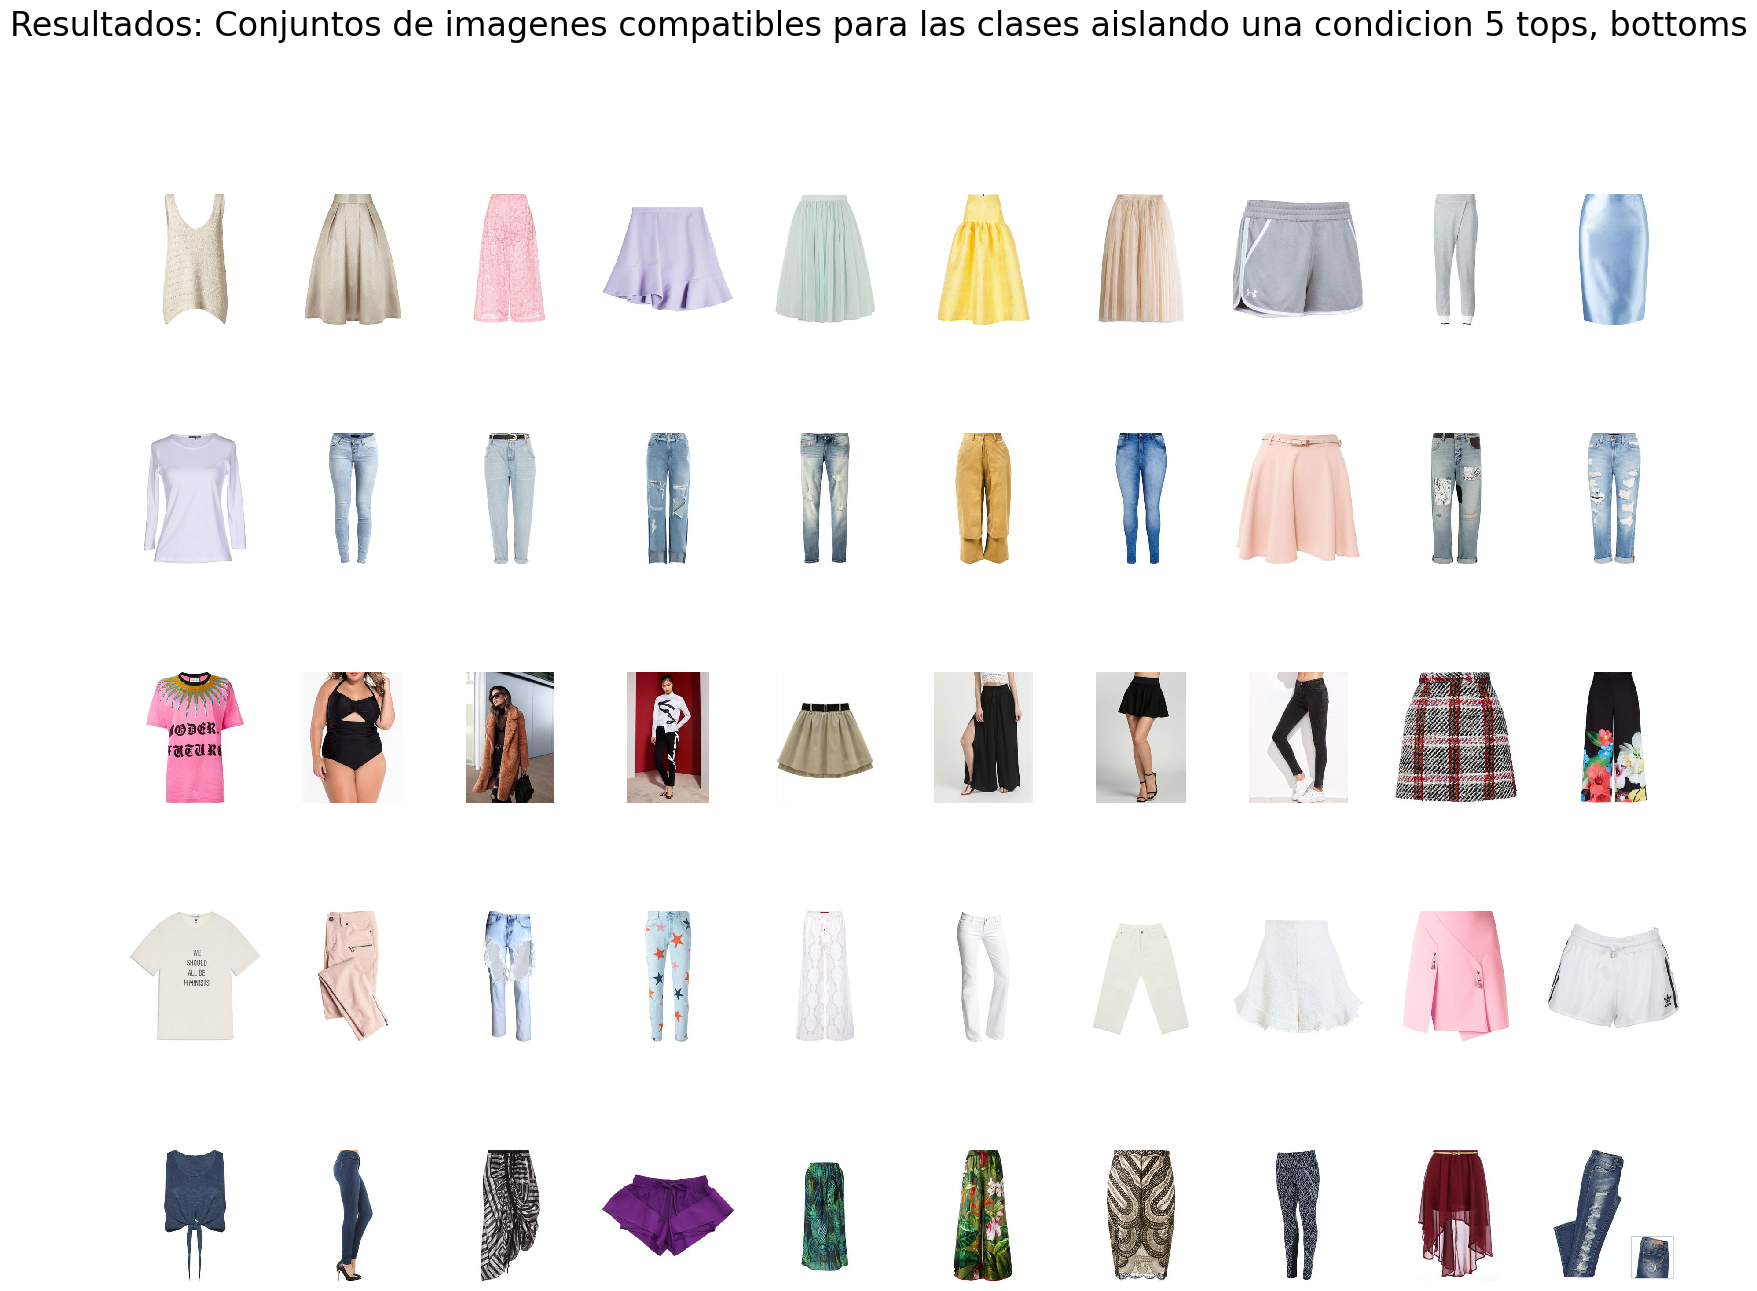

In [13]:
# se selecciona una condicion de typespaces de forma aleatoria
example_cond = [37]
final_embeddings_list = embeddings_list[:, example_cond, :].squeeze().cpu()
# random.sample(range(0, 66), 1)

# se obtienen las embeddings que solamente corresponden a la condicion establecida por example_cond
# y se retiran las categorias asociadas a esa clase
condition_value = {i for i in typespaces if typespaces[i]==example_cond[0]}
class1, class2 = condition_value.pop()

# leave only the vectors or images that correspond to class 1 or class 2
embeddings_list_class1, cat_list_class1, images_list_class1 = [], [], []
embeddings_list_class2, cat_list_class2, images_list_class2 = [], [], []

for i in range(len(final_embeddings_list)):
    if cat_list[i] == class1:
        img_embedding = torch.unsqueeze(final_embeddings_list[i,:].clone().detach(), 0)
        embeddings_list_class1.append(img_embedding)
        cat_list_class1.append(cat_list[i])
        images_list_class1.append(images_list[i])

    if cat_list[i] == class2:
        img_embedding = torch.unsqueeze(final_embeddings_list[i,:].clone().detach(), 0)
        embeddings_list_class2.append(img_embedding)
        cat_list_class2.append(cat_list[i])
        images_list_class2.append(images_list[i])

#embeddings_list_class1 = torch.cat(embeddings_list_class1)

# se eliguen n ejemplos que correspondan a la clase 1
n_ejemplos = 5
ejemplos = range(n_ejemplos)

num_tensors = len(embeddings_list_class1)
random_indices = random.choices(range(num_tensors), k=n_ejemplos)

ejemplos_class_1 = [embeddings_list_class1[i] for i in random_indices]
ejemplos_class_1_path = [images_list_class1[i] for i in random_indices]

ejemplos_class_1.extend(embeddings_list_class2)
ejemplos_class_1 = torch.cat(ejemplos_class_1)

ejemplos_class_1_path.extend(images_list_class2)

# se define el modelo NearestNeighbors
n_nbrs = 10
nbrs = NearestNeighbors(n_neighbors=n_nbrs).fit(ejemplos_class_1)
near_nei = nbrs.kneighbors(ejemplos_class_1[ejemplos, :], return_distance=False)

# crear figura y subplots
fig, ax = plt.subplots(n_ejemplos, n_nbrs, figsize=(20,15))

for j in range(n_ejemplos):
    for i in range(n_nbrs):
        image_id = near_nei[j, i]
        example_img = default_image_loader(ejemplos_class_1_path[image_id])
        ax[j,i].imshow(example_img, interpolation='nearest')
        titulo = str(image_id)

        ax[j, i].axis('off')


# titulo de la figura
fig.suptitle('Resultados: Conjuntos de imagenes compatibles para las clases aislando una condicion 5 %s, %s' % (class1, class2), fontsize=24)

# PSETS OF COMPATIBLE CLOTHES FOLDER
image_sets_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'plot_results', 'image_sets', args.name)

if not os.path.exists(image_sets_dir): os.makedirs(image_sets_dir)
plt.savefig(os.path.join(image_sets_dir, '{}.png'.format(int(time.time()))))

# 4. Metrica de varianza de color en una imagen

Se define una metrica para medir la varianza de colores en una imagen. Se utiliza esta metrica en las vestimentas de Polyvore Outfits para determinar si las vestimentas estan compuestas por un solo color o mas. Esto se generaliza para todas las vestimentas de Polyvore Outfits.

## a. Histograma de vestimenta

In [12]:
from __future__ import print_function
import argparse
import os
import sys
import shutil
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from PIL import Image
import itertools
import random
import time
import Resnet_18
from polyvore_outfits_csa import TripletImageLoader
from tripletnet import Tripletnet
from ConditionalSimNet_adapt import ConditionalSimNet
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors


def default_image_loader(path):
    return Image.open(path).convert('RGB')


def calculate_average_color(image_path, img_transform):
    image = Image.open(image_path).convert('RGB')
    image = img_transform(image)
    image_tensor = torch.from_numpy(np.array(image)).float().permute(2, 0, 1).unsqueeze(0).cuda()
    average_color = torch.mean(image_tensor, dim=(2, 3)).squeeze()
    return average_color / 255.0


def calculate_color_variance(image_paths, img_transform):
    avg_colors = []

    for image_path in image_paths:
        avg_color = calculate_average_color(image_path, img_transform)
        avg_colors.append(avg_color)

    avg_colors = torch.stack(avg_colors)
    color_variances = torch.var(avg_colors, dim=0)

    # Optionally, calculate the overall variance
    overall_variance = torch.mean(color_variances)

    return avg_colors, color_variances, overall_variance


# torch.set_printoptions(threshold=10_000)
torch.set_printoptions(profile="full")
cuda = torch.cuda.is_available()

if cuda: torch.cuda.manual_seed(1)

# se leen los archivos relevantes, archivo de metadatos, carpeta donde se encuentran las imagenes no disjuntas.
fn = os.path.join('../../polyvore_type_aware_data', 'polyvore_outfits', 'polyvore_item_metadata.json')
meta_data = json.load(open(fn, 'r'))
rootdir = os.path.join('../../polyvore_type_aware_data', 'polyvore_outfits', 'nondisjoint')
impath = os.path.join('../../polyvore_type_aware_data', 'polyvore_outfits', 'images')

# se abren los datos de entrenamiento
data_json = os.path.join(rootdir, 'train.json')
outfit_data = json.load(open(data_json, 'r'))

# transformation to apply to image
img_transform = transforms.CenterCrop(200)

# rgb means for clothes outfits and pairs of items
outfit_variance = []
total_pos_pairs_variance = []

# lists to save outfits data, general data of all items and positive pairs of items
outfit_index_list, outfit_rgb_means, outfit_cat_list, outfit_path_list = [], [], [], []
index_list, img_rgb_means, cat_list, path_list = [], [], [], []
pos_pairs_index_list, pos_pairs_rgb_means, pos_pairs_cat_list, pos_pairs_path_list = [], [], [], []

# get list of images and make a mapping used to quickly organize the data
contador = 0
for outfit in outfit_data:
    contador +=1
    outfit_id = outfit['set_id']

    # listas para guardar los paths, categorias y los items
    items_index_list, items_path_list, items_cat_list, items_img_rgb = [], [], [], []
    for item in outfit['items']:
        im = item['item_id']
        
        # image path, category and compute color variance
        im_path = os.path.join(impath, '%s.jpg' % im)
        im_category = meta_data[im]['semantic_category']
        im_rgb = calculate_average_color(im_path, img_transform)
        
        # append image path, category and color variance to general lists
        index_list.append(im)
        path_list.append(im_path)
        cat_list.append(im_category)
        img_rgb_means.append(im_rgb)
        
        # append item to outfit list of clothes items
        items_index_list.append(im)
        items_path_list.append(im_path)
        items_cat_list.append(im_category)
        items_img_rgb.append(im_rgb)
    
    
    # append data from pairs of positive items
    items = outfit['items']
    cnt = len(items)
    outfit_id = outfit['set_id']
    for j in range(cnt-1):
        for k in range(j+1, cnt):
            
            # retrieve the two items
            item1, item2 = items[j]['item_id'], items[k]['item_id']
        
            # append images_index, image path, category and color variance of pairs of positive items
            pos_pairs_index_list.append([item1, item2])
            pos_pairs_path_list.append([os.path.join(impath, '%s.jpg' % item1), os.path.join(impath, '%s.jpg' % item2)])
            pos_pairs_cat_list.append([meta_data[item1]['semantic_category'], meta_data[item2]['semantic_category']])
            pos_pairs_rgb_means.append([calculate_average_color(os.path.join(impath, '%s.jpg' % item1), img_transform), calculate_average_color(os.path.join(impath, '%s.jpg' % item2), img_transform)])            
            
            # compute average color, variance of colors and overall variance of pairs of positive items
            avg_colors, color_variances, overall_variance = calculate_color_variance([os.path.join(impath, '%s.jpg' % item1), os.path.join(impath, '%s.jpg' % item2)], img_transform)
            total_pos_pairs_variance.append(color_variances)
        
    
    outfit_index_list.append(items_index_list)
    outfit_path_list.append(items_path_list)
    outfit_cat_list.append(items_cat_list)
    outfit_rgb_means.append(items_img_rgb)
    
    # compute average color, variance of colors and overall variance in
    avg_colors, color_variances, overall_variance = calculate_color_variance(items_path_list, img_transform)
    outfit_variance.append(color_variances)
    

# compute outfit variance and pos pairs variance
total_outfit_variance = torch.concat(outfit_variance, 0)
total_outfit_variance_2 = torch.mean(total_outfit_variance, dim=0)
total_variation = torch.mean(total_outfit_variance_2)

total_pos_pairs_variance = torch.concat(total_pos_pairs_variance, 0)
total_pos_pairs_variance_2 = torch.mean(total_pos_pairs_variance, dim=0)
total_pos_pairs_variation = torch.mean(total_pos_pairs_variance_2)


In [13]:
total_pos_pairs_variation

tensor(0.0387, device='cuda:0')

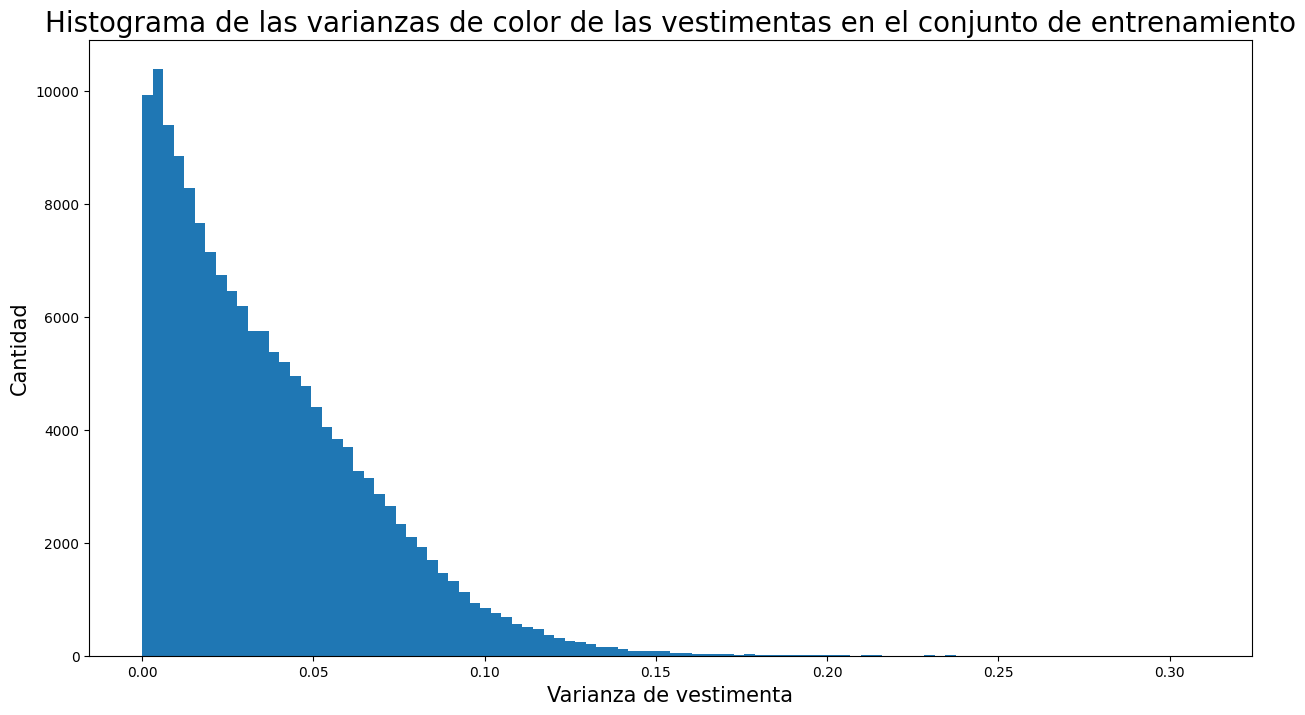

[8.45745518e-09 3.08521185e-03 6.17041532e-03 9.25561879e-03
 1.23408223e-02 1.54260257e-02 1.85112283e-02 2.15964317e-02
 2.46816352e-02 2.77668387e-02 3.08520421e-02 3.39372456e-02
 3.70224491e-02 4.01076525e-02 4.31928560e-02 4.62780595e-02
 4.93632630e-02 5.24484664e-02 5.55336699e-02 5.86188734e-02
 6.17040768e-02 6.47892803e-02 6.78744838e-02 7.09596872e-02
 7.40448907e-02 7.71300942e-02 8.02152976e-02 8.33005011e-02
 8.63857046e-02 8.94709080e-02 9.25561115e-02 9.56413150e-02
 9.87265185e-02 1.01811722e-01 1.04896925e-01 1.07982129e-01
 1.11067332e-01 1.14152536e-01 1.17237739e-01 1.20322943e-01
 1.23408146e-01 1.26493350e-01 1.29578546e-01 1.32663757e-01
 1.35748953e-01 1.38834164e-01 1.41919360e-01 1.45004570e-01
 1.48089767e-01 1.51174977e-01 1.54260173e-01 1.57345384e-01
 1.60430580e-01 1.63515791e-01 1.66600987e-01 1.69686198e-01
 1.72771394e-01 1.75856605e-01 1.78941801e-01 1.82027012e-01
 1.85112208e-01 1.88197419e-01 1.91282615e-01 1.94367826e-01
 1.97453022e-01 2.005382

In [15]:
variance_values = total_outfit_variance.cpu().numpy()


fig = plt.figure(figsize=(15,8))
n_plt, bins_plt, patches = plt.hist(variance_values, bins=100)

plt.title('Histograma de las varianzas de color de las vestimentas en el conjunto de entrenamiento', fontsize=20)
plt.xlabel('Varianza de vestimenta', fontsize=15)
plt.ylabel('Cantidad', fontsize=15)
plt.show()

print(bins_plt)

0.01400721 3.698067193909083e-06 0.014007209800183773


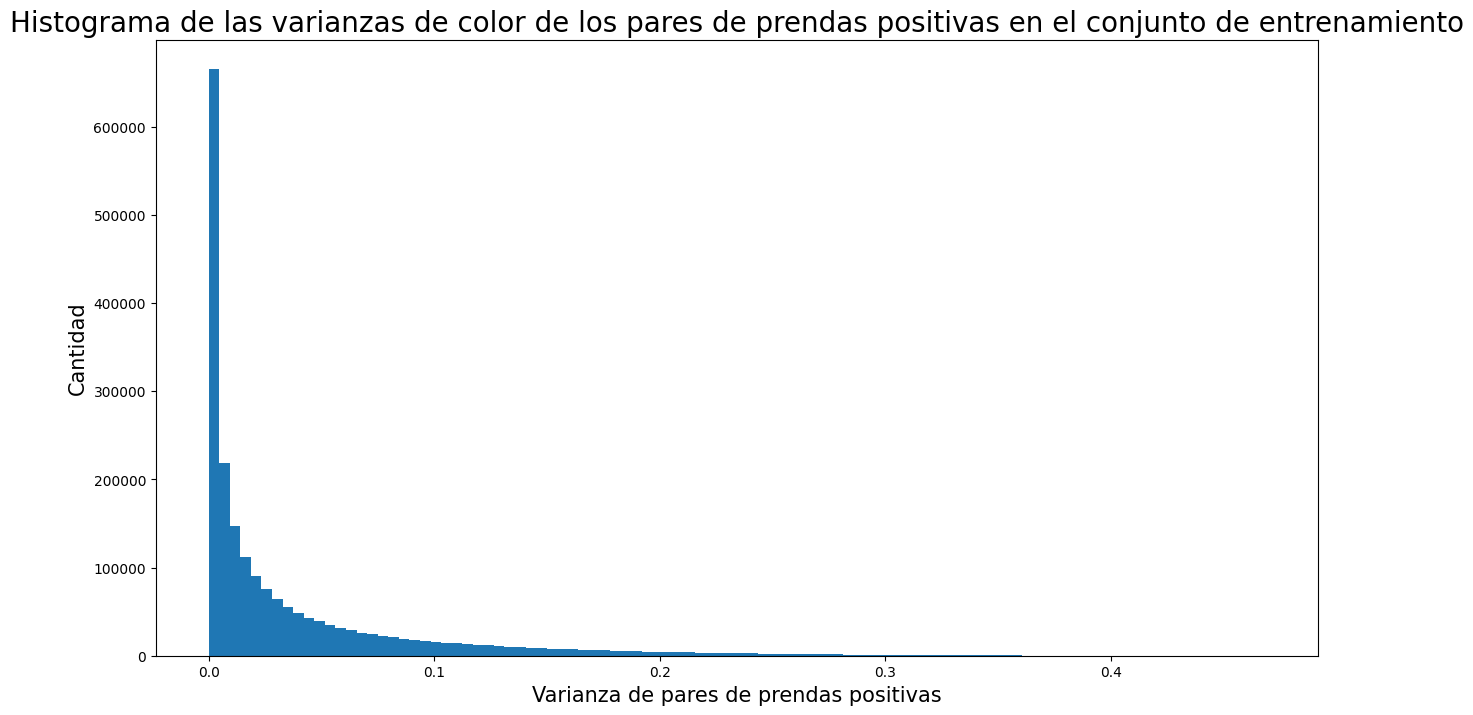

In [16]:
pos_pairs_var = total_pos_pairs_variance.cpu().numpy()
median_pos_pairs = np.median(pos_pairs_var)
print(median_pos_pairs, np.percentile(pos_pairs_var, 1), np.percentile(pos_pairs_var, 50))

fig = plt.figure(figsize=(15,8))

n_plt, bins_plt, patches = plt.hist(pos_pairs_var, bins=100)

plt.title('Histograma de las varianzas de color de los pares de prendas positivas en el conjunto de entrenamiento', fontsize=20)
plt.xlabel('Varianza de pares de prendas positivas', fontsize=15)
plt.ylabel('Cantidad', fontsize=15)
#plt.xlim(-10, 10)
#plt.ylim(-1, 1)

plt.show()

# 5. Naive Model for measuring Fashion Compatibility Tasks

Se implementa un modelo Naive considerando los colores de la prendas solamente. Se corta la imagen en el centro (200x200) y se computa la varianza por cada canal de color.
Se define el puntaje de una imagen como el promedio de los canales rgb y se computan los resultados en las tareas:
- FITB
- Fashion Compatibility

Tambien se recuperan imagenes de la base de datos que compatibilizan con distintas imagenes recuperadas al azar.

In [10]:
from __future__ import print_function
import argparse
import os
import sys
import shutil
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from PIL import Image
import itertools
import random
import time
import Resnet_18
from polyvore_outfits_csa import TripletImageLoader
from tripletnet import Tripletnet
from ConditionalSimNet_adapt import ConditionalSimNet
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors


from sklearn.neighbors import NearestNeighbors


def default_image_loader(path):
    return Image.open(path).convert('RGB')

def calculate_average_color(image_path, img_transform):
    image = Image.open(image_path).convert('RGB')
    image = img_transform(image)
    image_tensor = torch.from_numpy(np.array(image)).float().permute(2, 0, 1).unsqueeze(0).cuda()
    average_color = torch.mean(image_tensor, dim=(2, 3)).squeeze()
    return average_color / 255.0


def calculate_color_variance(image_paths, img_transform):
    avg_colors = []
    
    for image_path in image_paths:
        avg_color = calculate_average_color(image_path, img_transform)
        avg_colors.append(avg_color)

    avg_colors = torch.stack(avg_colors)
    color_variances = torch.var(avg_colors, dim=0)

    # Optionally, calculate the overall variance
    overall_variance = torch.mean(color_variances)

    return avg_colors, color_variances, overall_variance

os.environ["CUDA_VISIBLE_DEVICES"]="0"

# torch.set_printoptions(threshold=10_000)
torch.set_printoptions(profile="full")
cuda = torch.cuda.is_available()

if cuda: torch.cuda.manual_seed(1)

# se leen los archivos relevantes, archivo de metadatos, carpeta donde se encuentran las imagenes no disjuntas.
fn = os.path.join('../../polyvore_type_aware_data', 'polyvore_outfits', 'polyvore_item_metadata.json')
meta_data = json.load(open(fn, 'r'))
rootdir = os.path.join('../../polyvore_type_aware_data', 'polyvore_outfits', 'nondisjoint')
impath = os.path.join('../../polyvore_type_aware_data', 'polyvore_outfits', 'images')

# se abren los datos de entrenamiento
data_json = os.path.join(rootdir, 'test.json')
outfit_data = json.load(open(data_json, 'r'))

# transformation to apply to image
img_transform = transforms.CenterCrop(200)

rgb_means = []
outfit_index_list, outfit_rgb_means, outfit_cat_list, outfit_path_list, index_list, img_rgb_means, cat_list, path_list = [], [], [], [], [], [], [], []

# get list of images and make a mapping used to quickly organize the data
contador = 0
for outfit in outfit_data:
    contador +=1
    outfit_id = outfit['set_id']

    # listas para guardar los paths, categorias y los items
    items_index_list, items_path_list, items_cat_list, items_img_rgb = [], [], [], []
    for item in outfit['items']:
        im = item['item_id']
        
        # image path, category and compute color variance
        im_path = os.path.join(impath, '%s.jpg' % im)
        im_category = meta_data[im]['semantic_category']
        im_rgb = calculate_average_color(im_path, img_transform)
        
        # append image path, category and color variance to general lists
        index_list.append(im)
        path_list.append(im_path)
        cat_list.append(im_category)
        img_rgb_means.append(im_rgb)
        
        # append item to outfit list of clothes items
        items_index_list.append(im)
        items_path_list.append(im_path)
        items_cat_list.append(im_category)
        items_img_rgb.append(im_rgb)
    
    outfit_index_list.append(items_index_list)
    outfit_path_list.append(items_path_list)
    outfit_cat_list.append(items_cat_list)
    outfit_rgb_means.append(items_img_rgb)
    
    # compute average color, variance of colors and overall variance in 
    avg_colors, color_variances, overall_variance = calculate_color_variance(items_path_list, img_transform)
    rgb_means.append(color_variances)
    
    
#index_list = list(itertools.chain.from_iterable(index_list))
#img_rgb_means = list(itertools.chain.from_iterable(img_rgb_means))
#cat_list = list(itertools.chain.from_iterable(cat_list))
#path_list = list(itertools.chain.from_iterable(path_list))

## 5.1 Computacion de los puntajes en las metricas FITB y Fashion Compatibility

Se computa el puntaje en los datos de testeo en las metricas FITB y Fashion Compatibility.


### a. Outfit loss

In [11]:
from sklearn.metrics import roc_auc_score

def parse_iminfo(question, im2index, id2im, gt = None):
    """ Maps the questions from the FITB and compatibility tasks back to
        their index in the precomputed matrix of features

        question: List of images to measure compatibility between
        im2index: Dictionary mapping an image name to its location in a
                  precomputed matrix of features
        gt: optional, the ground truth outfit set this item belongs to
    """
    questions = []
    is_correct = np.zeros(len(question), bool)
    for index, im_id in enumerate(question):
        set_id = im_id.split('_')[0]
        if gt is None:
            gt = set_id

        im = id2im[im_id]
        questions.append((im2index[im], im))
        is_correct[index] = set_id == gt

    return questions, is_correct, gt



def load_compatibility_questions(fn, im2index, id2im):
    """ Returns the list of compatibility questions for the
        split """
    with open(fn, 'r') as f:
        lines = f.readlines()

    compatibility_questions = []
    for line in lines:
        data = line.strip().split()
        compat_question, _, _ = parse_iminfo(data[1:], im2index, id2im)
        compatibility_questions.append((compat_question, int(data[0])))

    return compatibility_questions

def load_fitb_questions(fn, im2index, id2im):
    """ Returns the list of fill in the blank questions for the
        split """
    data = json.load(open(fn, 'r'))
    questions = []
    for item in data:
        question = item['question']
        q_index, _, gt = parse_iminfo(question, im2index, id2im)
        answer = item['answers']
        a_index, is_correct, _ = parse_iminfo(answer, im2index, id2im, gt)
        questions.append((q_index, a_index, is_correct))

    return questions



def test_compatibility(embeds, metric, compatibility_questions, index_list, cat_list):
    """ Returns the area under a roc curve for the compatibility
        task

        embeds: precomputed embedding features used to score
                each compatibility question
        metric: a function used to score the elementwise product
                of a pair of embeddings, if None euclidean
                distance is used
    """
    scores = []
    labels = np.zeros(len(compatibility_questions), np.int32)
    for index, (outfit, label) in enumerate(compatibility_questions):
        labels[index] = label
        n_items = len(outfit)
        
        avg_colors = []
        for i in range(n_items-1):
            item1, img1 = outfit[i]
            item1_index = index_list.index(img1)
            avg_colors.append(embeds[item1_index].unsqueeze(0))
            #type1 = cat_list[item1_index]
            
        avg_colors = torch.cat(avg_colors, dim=0)
        color_variances = torch.mean(torch.var(avg_colors, dim=0))
        
        print(color_variances)
        scores.append(color_variances)

    scores = torch.cat(scores).squeeze().cpu().numpy()
    auc = roc_auc_score(labels, 1 - scores)
    return auc

def test_fitb(embeds, metric, fitb_questions, index_list, cat_list):
    """ Returns the accuracy of the fill in the blank task

        embeds: precomputed embedding features used to score
                each compatibility question
        metric: a function used to score the elementwise product
                of a pair of embeddings, if None euclidean
                distance is used
    """
    correct = 0.
    n_questions = 0.
    for q_index, (questions, answers, is_correct) in enumerate(fitb_questions):
        answer_score = np.zeros(len(answers), dtype=np.float32)
        for index, (answer, img1) in enumerate(answers):
            item1_index = index_list.index(img1)
            #type1 = cat_list[item1_index]
            
            score = 0
            avg_colors = [embeds[item1_index].unsqueeze(0)]
            #embed_compute.append()
            for question, img2 in questions:
                item2_index = index_list.index(img2)
                #type2 = cat_list[item2_index]
                avg_colors.append(embeds[item2_index].unsqueeze(0))
            
            avg_colors = torch.cat(avg_colors, dim=0)
            color_variances = torch.var(avg_colors, dim=0)

            # Optionally, calculate the overall variance
            answer_score[index] = torch.mean(color_variances).squeeze().cpu().numpy()

        correct += is_correct[np.argmin(answer_score)]
        n_questions += 1

    # scores are based on distances so need to convert them so higher is better
    acc = correct / n_questions
    return acc


rootdir = os.path.join('../../polyvore_type_aware_data', 'polyvore_outfits', 'nondisjoint')
impath = os.path.join('../../polyvore_type_aware_data', 'polyvore_outfits', 'images')

# se abren los datos de entrenamiento
data_json = os.path.join(rootdir, 'test.json')
outfit_data = json.load(open(data_json, 'r'))

# get list of images and make a mapping used to quickly organize the data
im2type = {}
category2ims = {}
imnames = set()
id2im = {}
for outfit in outfit_data:
    outfit_id = outfit['set_id']
    for item in outfit['items']:
        im = item['item_id']
        category = meta_data[im]['semantic_category']
        im2type[im] = category

        id2im['%s_%i' % (outfit_id, item['index'])] = im
        imnames.add(im)

imnames = list(imnames)
im2index = {}
for index, im in enumerate(imnames):
    im2index[im] = index



# pull the two task's questions for test and val splits
fn = os.path.join(rootdir, 'fill_in_blank_test.json')
fitb_questions = load_fitb_questions(fn, im2index, id2im)
fn = os.path.join(rootdir, 'compatibility_test.txt')
compatibility_questions = load_compatibility_questions(fn, im2index, id2im)

# se computan los valores en las metricas
acc = test_fitb(img_rgb_means, None, fitb_questions, index_list, cat_list)
auc = test_compatibility(img_rgb_means, None, compatibility_questions, index_list, cat_list)
#acc_var = test_fitb_var(embeddings, None, fitb_questions)
total = auc + acc # + acc_var
print('test set: Compat AUC: {:.2f} FITB: {:.1f}\n'.format(
    round(auc, 2), round(acc * 100, 1)))

return total

tensor(0.0097, device='cuda:0')
tensor(0.0558, device='cuda:0')
tensor(0.0082, device='cuda:0')
tensor(0.0042, device='cuda:0')
tensor(0.0773, device='cuda:0')
tensor(0.0070, device='cuda:0')
tensor(0.0360, device='cuda:0')
tensor(0.0645, device='cuda:0')
tensor(0.0616, device='cuda:0')
tensor(0.0630, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0195, device='cuda:0')
tensor(0.0125, device='cuda:0')
tensor(0.0418, device='cuda:0')
tensor(0.0367, device='cuda:0')
tensor(0.0395, device='cuda:0')
tensor(0.0243, device='cuda:0')
tensor(0.0754, device='cuda:0')
tensor(0.0506, device='cuda:0')
tensor(0.0221, device='cuda:0')
tensor(0.0017, device='cuda:0')
tensor(0.0336, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0524, device='cuda:0')
tensor(0.0093, device='cuda:0')
tensor(0.0522, device='cuda:0')
tensor(0.0243, device='cuda:0')
tensor(0.1023, device='cuda:0')
tensor(0.0335, device='cuda:0')
tensor(0.0425, device='cuda:0')
tensor(0.0166, device='cuda:0')
tensor(0.01

tensor(0.0368, device='cuda:0')
tensor(0.0376, device='cuda:0')
tensor(0.0036, device='cuda:0')
tensor(0.0315, device='cuda:0')
tensor(0.0517, device='cuda:0')
tensor(0.0643, device='cuda:0')
tensor(0.0069, device='cuda:0')
tensor(0.0711, device='cuda:0')
tensor(0.0647, device='cuda:0')
tensor(0.0514, device='cuda:0')
tensor(0.0502, device='cuda:0')
tensor(0.0475, device='cuda:0')
tensor(0.0222, device='cuda:0')
tensor(0.0121, device='cuda:0')
tensor(0.0206, device='cuda:0')
tensor(0.0294, device='cuda:0')
tensor(0.0540, device='cuda:0')
tensor(0.0566, device='cuda:0')
tensor(0.0023, device='cuda:0')
tensor(0.0203, device='cuda:0')
tensor(0.0014, device='cuda:0')
tensor(0.0010, device='cuda:0')
tensor(0.0371, device='cuda:0')
tensor(0.0576, device='cuda:0')
tensor(0.0354, device='cuda:0')
tensor(0.0496, device='cuda:0')
tensor(0.0331, device='cuda:0')
tensor(0.0536, device='cuda:0')
tensor(0.0110, device='cuda:0')
tensor(0.0052, device='cuda:0')
tensor(0.0433, device='cuda:0')
tensor(0

tensor(0.0065, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0211, device='cuda:0')
tensor(0.0344, device='cuda:0')
tensor(0.0140, device='cuda:0')
tensor(0.0167, device='cuda:0')
tensor(0.0466, device='cuda:0')
tensor(0.0840, device='cuda:0')
tensor(0.0118, device='cuda:0')
tensor(0.0069, device='cuda:0')
tensor(0.0126, device='cuda:0')
tensor(0.0862, device='cuda:0')
tensor(0.0112, device='cuda:0')
tensor(0.0027, device='cuda:0')
tensor(0.0279, device='cuda:0')
tensor(0.0844, device='cuda:0')
tensor(0.0916, device='cuda:0')
tensor(0.0028, device='cuda:0')
tensor(0.0476, device='cuda:0')
tensor(0.0730, device='cuda:0')
tensor(0.1064, device='cuda:0')
tensor(0.0866, device='cuda:0')
tensor(0.0271, device='cuda:0')
tensor(0.1253, device='cuda:0')
tensor(0.0017, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0016, device='cuda:0')
tensor(0.0953, device='cuda:0')
tensor(0.0828, device='cuda:0')
tensor(0.0314, device='cuda:0')
tensor(0.0416, device='cuda:0')
tensor(0.1058,

tensor(0.0228, device='cuda:0')
tensor(0.0160, device='cuda:0')
tensor(0.0087, device='cuda:0')
tensor(0.0111, device='cuda:0')
tensor(0.0327, device='cuda:0')
tensor(0.0326, device='cuda:0')
tensor(0.0461, device='cuda:0')
tensor(0.0404, device='cuda:0')
tensor(0.0905, device='cuda:0')
tensor(0.0516, device='cuda:0')
tensor(0.0304, device='cuda:0')
tensor(0.0700, device='cuda:0')
tensor(0.2000, device='cuda:0')
tensor(0.0173, device='cuda:0')
tensor(0.0401, device='cuda:0')
tensor(0.0068, device='cuda:0')
tensor(0.0168, device='cuda:0')
tensor(0.0115, device='cuda:0')
tensor(0.0210, device='cuda:0')
tensor(0.0628, device='cuda:0')
tensor(0.0058, device='cuda:0')
tensor(0.0107, device='cuda:0')
tensor(0.0190, device='cuda:0')
tensor(0.0269, device='cuda:0')
tensor(0.0069, device='cuda:0')
tensor(0.0390, device='cuda:0')
tensor(0.0760, device='cuda:0')
tensor(0.0159, device='cuda:0')
tensor(0.1124, device='cuda:0')
tensor(0.0607, device='cuda:0')
tensor(0.0228, device='cuda:0')
tensor(0

tensor(0.0267, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0070, device='cuda:0')
tensor(0.0011, device='cuda:0')
tensor(0.0656, device='cuda:0')
tensor(0.0518, device='cuda:0')
tensor(0.0134, device='cuda:0')
tensor(0.0064, device='cuda:0')
tensor(0.0372, device='cuda:0')
tensor(0.0455, device='cuda:0')
tensor(0.0051, device='cuda:0')
tensor(0.0456, device='cuda:0')
tensor(0.0315, device='cuda:0')
tensor(0.0665, device='cuda:0')
tensor(0.0290, device='cuda:0')
tensor(0.0275, device='cuda:0')
tensor(0.0052, device='cuda:0')
tensor(0.0095, device='cuda:0')
tensor(0.0051, device='cuda:0')
tensor(0.0676, device='cuda:0')
tensor(0.0592, device='cuda:0')
tensor(0.0079, device='cuda:0')
tensor(0.0563, device='cuda:0')
tensor(0.0606, device='cuda:0')
tensor(0.0389, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0909, device='cuda:0')
tensor(0.0020, device='cuda:0')
tensor(0.0394, device='cuda:0')
tensor(0.0115, device='cuda:0')
tensor(0.0541, device='cuda:0')
tensor(0.06

tensor(0.0569, device='cuda:0')
tensor(0.0794, device='cuda:0')
tensor(0.0273, device='cuda:0')
tensor(0.0551, device='cuda:0')
tensor(0.0444, device='cuda:0')
tensor(0.0252, device='cuda:0')
tensor(0.0080, device='cuda:0')
tensor(0.0197, device='cuda:0')
tensor(0.0075, device='cuda:0')
tensor(0.0014, device='cuda:0')
tensor(0.0366, device='cuda:0')
tensor(0.0234, device='cuda:0')
tensor(0.0118, device='cuda:0')
tensor(0.0518, device='cuda:0')
tensor(0.0022, device='cuda:0')
tensor(0.0585, device='cuda:0')
tensor(0.0483, device='cuda:0')
tensor(0.0056, device='cuda:0')
tensor(0.1601, device='cuda:0')
tensor(0.0196, device='cuda:0')
tensor(0.0852, device='cuda:0')
tensor(0.0786, device='cuda:0')
tensor(0.0490, device='cuda:0')
tensor(0.0588, device='cuda:0')
tensor(0.0311, device='cuda:0')
tensor(0.0155, device='cuda:0')
tensor(0.1628, device='cuda:0')
tensor(0.0798, device='cuda:0')
tensor(0.0612, device='cuda:0')
tensor(0.0507, device='cuda:0')
tensor(0.0128, device='cuda:0')
tensor(0

tensor(0.0063, device='cuda:0')
tensor(0.0197, device='cuda:0')
tensor(0.0497, device='cuda:0')
tensor(0.0030, device='cuda:0')
tensor(0.0389, device='cuda:0')
tensor(0.1002, device='cuda:0')
tensor(6.2752e-05, device='cuda:0')
tensor(0.0737, device='cuda:0')
tensor(0.0323, device='cuda:0')
tensor(0.0175, device='cuda:0')
tensor(0.0064, device='cuda:0')
tensor(0.0722, device='cuda:0')
tensor(0.0770, device='cuda:0')
tensor(0.0248, device='cuda:0')
tensor(0.0808, device='cuda:0')
tensor(0.0157, device='cuda:0')
tensor(0.0066, device='cuda:0')
tensor(0.0306, device='cuda:0')
tensor(0.0463, device='cuda:0')
tensor(0.0023, device='cuda:0')
tensor(0.0120, device='cuda:0')
tensor(0.0262, device='cuda:0')
tensor(0.0628, device='cuda:0')
tensor(0.0330, device='cuda:0')
tensor(0.0048, device='cuda:0')
tensor(0.0449, device='cuda:0')
tensor(0.0354, device='cuda:0')
tensor(0.0697, device='cuda:0')
tensor(0.0082, device='cuda:0')
tensor(0.0635, device='cuda:0')
tensor(0.0024, device='cuda:0')
tens

tensor(0.0143, device='cuda:0')
tensor(0.0469, device='cuda:0')
tensor(0.0108, device='cuda:0')
tensor(0.0178, device='cuda:0')
tensor(0.0798, device='cuda:0')
tensor(0.0196, device='cuda:0')
tensor(0.0582, device='cuda:0')
tensor(0.0116, device='cuda:0')
tensor(0.0100, device='cuda:0')
tensor(0.0256, device='cuda:0')
tensor(0.0625, device='cuda:0')
tensor(0.0163, device='cuda:0')
tensor(0.0628, device='cuda:0')
tensor(0.0744, device='cuda:0')
tensor(0.0509, device='cuda:0')
tensor(0.0375, device='cuda:0')
tensor(0.0583, device='cuda:0')
tensor(0.0386, device='cuda:0')
tensor(0.0693, device='cuda:0')
tensor(8.5022e-05, device='cuda:0')
tensor(0.0206, device='cuda:0')
tensor(0.0413, device='cuda:0')
tensor(0.0124, device='cuda:0')
tensor(0.0272, device='cuda:0')
tensor(0.0055, device='cuda:0')
tensor(0.0918, device='cuda:0')
tensor(0.0407, device='cuda:0')
tensor(0.0133, device='cuda:0')
tensor(0.0047, device='cuda:0')
tensor(0.0139, device='cuda:0')
tensor(0.0317, device='cuda:0')
tens

tensor(0.0174, device='cuda:0')
tensor(0.0165, device='cuda:0')
tensor(0.0477, device='cuda:0')
tensor(0.0440, device='cuda:0')
tensor(0.0253, device='cuda:0')
tensor(0.0014, device='cuda:0')
tensor(0.0143, device='cuda:0')
tensor(0.0036, device='cuda:0')
tensor(0.0094, device='cuda:0')
tensor(0.0036, device='cuda:0')
tensor(0.0187, device='cuda:0')
tensor(0.0252, device='cuda:0')
tensor(0.0345, device='cuda:0')
tensor(0.0074, device='cuda:0')
tensor(0.0470, device='cuda:0')
tensor(0.0299, device='cuda:0')
tensor(0.0444, device='cuda:0')
tensor(0.0444, device='cuda:0')
tensor(0.0783, device='cuda:0')
tensor(0.0766, device='cuda:0')
tensor(0.0504, device='cuda:0')
tensor(0.0297, device='cuda:0')
tensor(0.0341, device='cuda:0')
tensor(0.0276, device='cuda:0')
tensor(0.0362, device='cuda:0')
tensor(0.0322, device='cuda:0')
tensor(0.0007, device='cuda:0')
tensor(0.0238, device='cuda:0')
tensor(0.0779, device='cuda:0')
tensor(0.0456, device='cuda:0')
tensor(0.0206, device='cuda:0')
tensor(0

tensor(0.0236, device='cuda:0')
tensor(0.0731, device='cuda:0')
tensor(0.0205, device='cuda:0')
tensor(0.0221, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0158, device='cuda:0')
tensor(0.0330, device='cuda:0')
tensor(0.0211, device='cuda:0')
tensor(0.1319, device='cuda:0')
tensor(0.0465, device='cuda:0')
tensor(0.0444, device='cuda:0')
tensor(0.0512, device='cuda:0')
tensor(0.0697, device='cuda:0')
tensor(0.0256, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0410, device='cuda:0')
tensor(0.0968, device='cuda:0')
tensor(0.0441, device='cuda:0')
tensor(0.0664, device='cuda:0')
tensor(0.0419, device='cuda:0')
tensor(0.0268, device='cuda:0')
tensor(0.0391, device='cuda:0')
tensor(0.0686, device='cuda:0')
tensor(0.0365, device='cuda:0')
tensor(0.0417, device='cuda:0')
tensor(0.0632, device='cuda:0')
tensor(0.1144, device='cuda:0')
tensor(0.0125, device='cuda:0')
tensor(0.0066, device='cuda:0')
tensor(0.0202, device='cuda:0')
tensor(0.0043, device='cuda:0')
tensor(0

tensor(0.0300, device='cuda:0')
tensor(0.0265, device='cuda:0')
tensor(0.0928, device='cuda:0')
tensor(0.0590, device='cuda:0')
tensor(0.0257, device='cuda:0')
tensor(0.0003, device='cuda:0')
tensor(0.0524, device='cuda:0')
tensor(0.0330, device='cuda:0')
tensor(0.1227, device='cuda:0')
tensor(0.0163, device='cuda:0')
tensor(0.0055, device='cuda:0')
tensor(0.0416, device='cuda:0')
tensor(0.0116, device='cuda:0')
tensor(0.0365, device='cuda:0')
tensor(0.0017, device='cuda:0')
tensor(0.0063, device='cuda:0')
tensor(0.0070, device='cuda:0')
tensor(0.0285, device='cuda:0')
tensor(0.0558, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0350, device='cuda:0')
tensor(0.0241, device='cuda:0')
tensor(0.0366, device='cuda:0')
tensor(0.0656, device='cuda:0')
tensor(0.0461, device='cuda:0')
tensor(0.0241, device='cuda:0')
tensor(0.0352, device='cuda:0')
tensor(0.0222, device='cuda:0')
tensor(0.0435, device='cuda:0')
tensor(0.0292, device='cuda:0')
tensor(0.0642, device='cuda:0')
tensor(0

tensor(0.0238, device='cuda:0')
tensor(0.0404, device='cuda:0')
tensor(0.0151, device='cuda:0')
tensor(0.0522, device='cuda:0')
tensor(0.0139, device='cuda:0')
tensor(0.0942, device='cuda:0')
tensor(0.0547, device='cuda:0')
tensor(0.0280, device='cuda:0')
tensor(0.0479, device='cuda:0')
tensor(0.0701, device='cuda:0')
tensor(0.0903, device='cuda:0')
tensor(0.0079, device='cuda:0')
tensor(0.0943, device='cuda:0')
tensor(0.0127, device='cuda:0')
tensor(0.0214, device='cuda:0')
tensor(0.0067, device='cuda:0')
tensor(0.0944, device='cuda:0')
tensor(0.0774, device='cuda:0')
tensor(0.0626, device='cuda:0')
tensor(0.0390, device='cuda:0')
tensor(0.0193, device='cuda:0')
tensor(0.0445, device='cuda:0')
tensor(0.0206, device='cuda:0')
tensor(0.0265, device='cuda:0')
tensor(0.0276, device='cuda:0')
tensor(0.0292, device='cuda:0')
tensor(0.0232, device='cuda:0')
tensor(0.0178, device='cuda:0')
tensor(0.0155, device='cuda:0')
tensor(0.0386, device='cuda:0')
tensor(0.1472, device='cuda:0')
tensor(0

tensor(0.0538, device='cuda:0')
tensor(0.0204, device='cuda:0')
tensor(0.0079, device='cuda:0')
tensor(0.0657, device='cuda:0')
tensor(0.0422, device='cuda:0')
tensor(0.0386, device='cuda:0')
tensor(0.0376, device='cuda:0')
tensor(0.0262, device='cuda:0')
tensor(0.0178, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0273, device='cuda:0')
tensor(0.0074, device='cuda:0')
tensor(0.0061, device='cuda:0')
tensor(0.1121, device='cuda:0')
tensor(0.0609, device='cuda:0')
tensor(0.0173, device='cuda:0')
tensor(0.0005, device='cuda:0')
tensor(0.0029, device='cuda:0')
tensor(0.0427, device='cuda:0')
tensor(0.0216, device='cuda:0')
tensor(0.0067, device='cuda:0')
tensor(0.0052, device='cuda:0')
tensor(0.0188, device='cuda:0')
tensor(0.0132, device='cuda:0')
tensor(0.0239, device='cuda:0')
tensor(0.0055, device='cuda:0')
tensor(0.1160, device='cuda:0')
tensor(0.0786, device='cuda:0')
tensor(0.0609, device='cuda:0')
tensor(0.0277, device='cuda:0')
tensor(0.0156, device='cuda:0')
tensor(0

tensor(0.0031, device='cuda:0')
tensor(0.0238, device='cuda:0')
tensor(0.1021, device='cuda:0')
tensor(0.0019, device='cuda:0')
tensor(0.0159, device='cuda:0')
tensor(0.0456, device='cuda:0')
tensor(0.0019, device='cuda:0')
tensor(0.0433, device='cuda:0')
tensor(0.0241, device='cuda:0')
tensor(0.0686, device='cuda:0')
tensor(0.0092, device='cuda:0')
tensor(0.0196, device='cuda:0')
tensor(0.0528, device='cuda:0')
tensor(0.0095, device='cuda:0')
tensor(0.0396, device='cuda:0')
tensor(0.0368, device='cuda:0')
tensor(0.0328, device='cuda:0')
tensor(0.0369, device='cuda:0')
tensor(0.0187, device='cuda:0')
tensor(0.0515, device='cuda:0')
tensor(0.0534, device='cuda:0')
tensor(0.0227, device='cuda:0')
tensor(0.0977, device='cuda:0')
tensor(0.0958, device='cuda:0')
tensor(0.0529, device='cuda:0')
tensor(0.0033, device='cuda:0')
tensor(0.0584, device='cuda:0')
tensor(0.0236, device='cuda:0')
tensor(0.0820, device='cuda:0')
tensor(0.0179, device='cuda:0')
tensor(0.0054, device='cuda:0')
tensor(0

tensor(0.0299, device='cuda:0')
tensor(0.0112, device='cuda:0')
tensor(0.0283, device='cuda:0')
tensor(0.0360, device='cuda:0')
tensor(0.1119, device='cuda:0')
tensor(0.0052, device='cuda:0')
tensor(0.0007, device='cuda:0')
tensor(0.0897, device='cuda:0')
tensor(0.0233, device='cuda:0')
tensor(0.0329, device='cuda:0')
tensor(0.0891, device='cuda:0')
tensor(0.0220, device='cuda:0')
tensor(0.1578, device='cuda:0')
tensor(0.0147, device='cuda:0')
tensor(0.0119, device='cuda:0')
tensor(0.0290, device='cuda:0')
tensor(0.0078, device='cuda:0')
tensor(0.0140, device='cuda:0')
tensor(0.0458, device='cuda:0')
tensor(0.0035, device='cuda:0')
tensor(0.0485, device='cuda:0')
tensor(0.0130, device='cuda:0')
tensor(0.0537, device='cuda:0')
tensor(0.0072, device='cuda:0')
tensor(0.0167, device='cuda:0')
tensor(0.0435, device='cuda:0')
tensor(0.0010, device='cuda:0')
tensor(0.0321, device='cuda:0')
tensor(0.0221, device='cuda:0')
tensor(0.0222, device='cuda:0')
tensor(0.0506, device='cuda:0')
tensor(0

tensor(0.0341, device='cuda:0')
tensor(0.0011, device='cuda:0')
tensor(0.0260, device='cuda:0')
tensor(0.0986, device='cuda:0')
tensor(0.0613, device='cuda:0')
tensor(0.0005, device='cuda:0')
tensor(0.0283, device='cuda:0')
tensor(0.0014, device='cuda:0')
tensor(0.0566, device='cuda:0')
tensor(0.0335, device='cuda:0')
tensor(0.0306, device='cuda:0')
tensor(0.0720, device='cuda:0')
tensor(0.0291, device='cuda:0')
tensor(0.0146, device='cuda:0')
tensor(0.0995, device='cuda:0')
tensor(0.0241, device='cuda:0')
tensor(0.0412, device='cuda:0')
tensor(0.0272, device='cuda:0')
tensor(0.0377, device='cuda:0')
tensor(0.0465, device='cuda:0')
tensor(0.0725, device='cuda:0')
tensor(0.0018, device='cuda:0')
tensor(0.0068, device='cuda:0')
tensor(0.0918, device='cuda:0')
tensor(0.0260, device='cuda:0')
tensor(0.0057, device='cuda:0')
tensor(0.0061, device='cuda:0')
tensor(0.0241, device='cuda:0')
tensor(0.0371, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0558, device='cuda:0')
tensor(0.03

tensor(0.0016, device='cuda:0')
tensor(0.0590, device='cuda:0')
tensor(0.0351, device='cuda:0')
tensor(0.0370, device='cuda:0')
tensor(0.0364, device='cuda:0')
tensor(0.0691, device='cuda:0')
tensor(0.0039, device='cuda:0')
tensor(0.0032, device='cuda:0')
tensor(0.0017, device='cuda:0')
tensor(0.0178, device='cuda:0')
tensor(0.0332, device='cuda:0')
tensor(0.0476, device='cuda:0')
tensor(0.0031, device='cuda:0')
tensor(0.0081, device='cuda:0')
tensor(0.0618, device='cuda:0')
tensor(0.0111, device='cuda:0')
tensor(0.1324, device='cuda:0')
tensor(0.0151, device='cuda:0')
tensor(0.0721, device='cuda:0')
tensor(0.0293, device='cuda:0')
tensor(0.0111, device='cuda:0')
tensor(0.0074, device='cuda:0')
tensor(0.0381, device='cuda:0')
tensor(0.0434, device='cuda:0')
tensor(0.0111, device='cuda:0')
tensor(0.0179, device='cuda:0')
tensor(0.0058, device='cuda:0')
tensor(0.0227, device='cuda:0')
tensor(0.0013, device='cuda:0')
tensor(0.0665, device='cuda:0')
tensor(0.0424, device='cuda:0')
tensor(0

tensor(0.1054, device='cuda:0')
tensor(0.0095, device='cuda:0')
tensor(0.0149, device='cuda:0')
tensor(0.0143, device='cuda:0')
tensor(0.0347, device='cuda:0')
tensor(0.0578, device='cuda:0')
tensor(0.0421, device='cuda:0')
tensor(0.0107, device='cuda:0')
tensor(0.0769, device='cuda:0')
tensor(0.0223, device='cuda:0')
tensor(0.0174, device='cuda:0')
tensor(0.2060, device='cuda:0')
tensor(0.0202, device='cuda:0')
tensor(0.0001, device='cuda:0')
tensor(0.0267, device='cuda:0')
tensor(0.0100, device='cuda:0')
tensor(0.0899, device='cuda:0')
tensor(0.0435, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0588, device='cuda:0')
tensor(0.0375, device='cuda:0')
tensor(0.0298, device='cuda:0')
tensor(0.0060, device='cuda:0')
tensor(0.0652, device='cuda:0')
tensor(0.0920, device='cuda:0')
tensor(0.0896, device='cuda:0')
tensor(0.0178, device='cuda:0')
tensor(0.0940, device='cuda:0')
tensor(0.0111, device='cuda:0')
tensor(0.0044, device='cuda:0')
tensor(0.0079, device='cuda:0')
tensor(0.02

tensor(0.0405, device='cuda:0')
tensor(0.0072, device='cuda:0')
tensor(0.0566, device='cuda:0')
tensor(0.0026, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0374, device='cuda:0')
tensor(0.0270, device='cuda:0')
tensor(0.0321, device='cuda:0')
tensor(0.0057, device='cuda:0')
tensor(0.0214, device='cuda:0')
tensor(0.0028, device='cuda:0')
tensor(0.0731, device='cuda:0')
tensor(0.1655, device='cuda:0')
tensor(0.0753, device='cuda:0')
tensor(0.1044, device='cuda:0')
tensor(0.0908, device='cuda:0')
tensor(0.0254, device='cuda:0')
tensor(0.0452, device='cuda:0')
tensor(0.0402, device='cuda:0')
tensor(0.0176, device='cuda:0')
tensor(0.0884, device='cuda:0')
tensor(0.0954, device='cuda:0')
tensor(0.0040, device='cuda:0')
tensor(0.0033, device='cuda:0')
tensor(0.1387, device='cuda:0')
tensor(0.0064, device='cuda:0')
tensor(0.0078, device='cuda:0')
tensor(0.0017, device='cuda:0')
tensor(0.0092, device='cuda:0')
tensor(0.0291, device='cuda:0')
tensor(0.0603, device='cuda:0')
tensor(0

tensor(0.0942, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0766, device='cuda:0')
tensor(0.0307, device='cuda:0')
tensor(0.0444, device='cuda:0')
tensor(0.0741, device='cuda:0')
tensor(0.0455, device='cuda:0')
tensor(0.0117, device='cuda:0')
tensor(0.0464, device='cuda:0')
tensor(0.0093, device='cuda:0')
tensor(0.0268, device='cuda:0')
tensor(0.0254, device='cuda:0')
tensor(0.1253, device='cuda:0')
tensor(0.0396, device='cuda:0')
tensor(0.0809, device='cuda:0')
tensor(0.0086, device='cuda:0')
tensor(0.0061, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0122, device='cuda:0')
tensor(0.0282, device='cuda:0')
tensor(0.0541, device='cuda:0')
tensor(0.0258, device='cuda:0')
tensor(0.0140, device='cuda:0')
tensor(0.1679, device='cuda:0')
tensor(0.0320, device='cuda:0')
tensor(0.0235, device='cuda:0')
tensor(0.0205, device='cuda:0')
tensor(0.0415, device='cuda:0')
tensor(0.0463, device='cuda:0')
tensor(0.0208, device='cuda:0')
tensor(0.0513, device='cuda:0')
tensor(0.0213,

tensor(0.0484, device='cuda:0')
tensor(0.0288, device='cuda:0')
tensor(0.0095, device='cuda:0')
tensor(0.0016, device='cuda:0')
tensor(0.0822, device='cuda:0')
tensor(0.0013, device='cuda:0')
tensor(0.0431, device='cuda:0')
tensor(0.0181, device='cuda:0')
tensor(0.0289, device='cuda:0')
tensor(0.0137, device='cuda:0')
tensor(0.0013, device='cuda:0')
tensor(0.0039, device='cuda:0')
tensor(0.0061, device='cuda:0')
tensor(0.0022, device='cuda:0')
tensor(0.0031, device='cuda:0')
tensor(0.1647, device='cuda:0')
tensor(0.0396, device='cuda:0')
tensor(0.0431, device='cuda:0')
tensor(0.0258, device='cuda:0')
tensor(0.0158, device='cuda:0')
tensor(0.0665, device='cuda:0')
tensor(0.0335, device='cuda:0')
tensor(0.0110, device='cuda:0')
tensor(0.0073, device='cuda:0')
tensor(0.0555, device='cuda:0')
tensor(0.0644, device='cuda:0')
tensor(0.0307, device='cuda:0')
tensor(0.0486, device='cuda:0')
tensor(0.0213, device='cuda:0')
tensor(0.0249, device='cuda:0')
tensor(0.0211, device='cuda:0')
tensor(0

tensor(0.0126, device='cuda:0')
tensor(0.0451, device='cuda:0')
tensor(0.0057, device='cuda:0')
tensor(0.0400, device='cuda:0')
tensor(0.0268, device='cuda:0')
tensor(0.0479, device='cuda:0')
tensor(0.0821, device='cuda:0')
tensor(0.0326, device='cuda:0')
tensor(0.0584, device='cuda:0')
tensor(0.0530, device='cuda:0')
tensor(0.0404, device='cuda:0')
tensor(0.0124, device='cuda:0')
tensor(0.0085, device='cuda:0')
tensor(0.1008, device='cuda:0')
tensor(0.0243, device='cuda:0')
tensor(0.0087, device='cuda:0')
tensor(0.0310, device='cuda:0')
tensor(0.0186, device='cuda:0')
tensor(0.0047, device='cuda:0')
tensor(0.0762, device='cuda:0')
tensor(0.0576, device='cuda:0')
tensor(0.0453, device='cuda:0')
tensor(0.0358, device='cuda:0')
tensor(0.0230, device='cuda:0')
tensor(0.1141, device='cuda:0')
tensor(0.0428, device='cuda:0')
tensor(0.0343, device='cuda:0')
tensor(0.0314, device='cuda:0')
tensor(0.0759, device='cuda:0')
tensor(0.0289, device='cuda:0')
tensor(0.0633, device='cuda:0')
tensor(0

tensor(0.0116, device='cuda:0')
tensor(0.0692, device='cuda:0')
tensor(0.1059, device='cuda:0')
tensor(0.0126, device='cuda:0')
tensor(0.0620, device='cuda:0')
tensor(0.0121, device='cuda:0')
tensor(0.0234, device='cuda:0')
tensor(0.0127, device='cuda:0')
tensor(0.0051, device='cuda:0')
tensor(0.0176, device='cuda:0')
tensor(0.0111, device='cuda:0')
tensor(0.0014, device='cuda:0')
tensor(0.0124, device='cuda:0')
tensor(0.0321, device='cuda:0')
tensor(0.0510, device='cuda:0')
tensor(0.0358, device='cuda:0')
tensor(0.0418, device='cuda:0')
tensor(0.0381, device='cuda:0')
tensor(0.0980, device='cuda:0')
tensor(0.1122, device='cuda:0')
tensor(0.0257, device='cuda:0')
tensor(0.0825, device='cuda:0')
tensor(0.0676, device='cuda:0')
tensor(0.0300, device='cuda:0')
tensor(0.0130, device='cuda:0')
tensor(0.0079, device='cuda:0')
tensor(0.0063, device='cuda:0')
tensor(0.0643, device='cuda:0')
tensor(0.0325, device='cuda:0')
tensor(0.0052, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.06

tensor(0.0317, device='cuda:0')
tensor(0.0389, device='cuda:0')
tensor(0.0255, device='cuda:0')
tensor(0.0750, device='cuda:0')
tensor(0.0631, device='cuda:0')
tensor(0.0102, device='cuda:0')
tensor(0.0851, device='cuda:0')
tensor(0.0252, device='cuda:0')
tensor(0.0034, device='cuda:0')
tensor(0.0045, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0223, device='cuda:0')
tensor(0.0224, device='cuda:0')
tensor(0.0663, device='cuda:0')
tensor(0.0151, device='cuda:0')
tensor(0.0609, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0431, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0297, device='cuda:0')
tensor(0.0262, device='cuda:0')
tensor(0.0406, device='cuda:0')
tensor(0.0231, device='cuda:0')
tensor(0.0022, device='cuda:0')
tensor(0.0553, device='cuda:0')
tensor(0.0973, device='cuda:0')
tensor(0.0657, device='cuda:0')
tensor(0.0467, device='cuda:0')
tensor(0.0381, device='cuda:0')
tensor(0.0234, device='cuda:0')
tensor(5.3123e-05, device='cuda:0')
tensor(

tensor(0.0461, device='cuda:0')
tensor(0.0436, device='cuda:0')
tensor(0.0233, device='cuda:0')
tensor(0.0109, device='cuda:0')
tensor(0.0598, device='cuda:0')
tensor(0.0136, device='cuda:0')
tensor(0.0168, device='cuda:0')
tensor(0.0364, device='cuda:0')
tensor(0.0073, device='cuda:0')
tensor(0.0078, device='cuda:0')
tensor(0.0145, device='cuda:0')
tensor(0.0269, device='cuda:0')
tensor(0.0152, device='cuda:0')
tensor(0.1612, device='cuda:0')
tensor(0.0521, device='cuda:0')
tensor(0.0107, device='cuda:0')
tensor(0.0723, device='cuda:0')
tensor(0.0049, device='cuda:0')
tensor(0.0145, device='cuda:0')
tensor(0.0690, device='cuda:0')
tensor(0.0131, device='cuda:0')
tensor(0.0291, device='cuda:0')
tensor(0.0388, device='cuda:0')
tensor(0.0245, device='cuda:0')
tensor(0.0726, device='cuda:0')
tensor(0.1582, device='cuda:0')
tensor(0.0107, device='cuda:0')
tensor(0.1470, device='cuda:0')
tensor(0.0495, device='cuda:0')
tensor(0.0039, device='cuda:0')
tensor(0.0067, device='cuda:0')
tensor(0

tensor(0.0160, device='cuda:0')
tensor(0.1606, device='cuda:0')
tensor(0.0435, device='cuda:0')
tensor(0.0058, device='cuda:0')
tensor(0.0383, device='cuda:0')
tensor(0.0635, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.1378, device='cuda:0')
tensor(0.0856, device='cuda:0')
tensor(0.0193, device='cuda:0')
tensor(0.0287, device='cuda:0')
tensor(0.0351, device='cuda:0')
tensor(0.0443, device='cuda:0')
tensor(0.0589, device='cuda:0')
tensor(0.0113, device='cuda:0')
tensor(0.0340, device='cuda:0')
tensor(0.0137, device='cuda:0')
tensor(0.0362, device='cuda:0')
tensor(0.0392, device='cuda:0')
tensor(0.0159, device='cuda:0')
tensor(0.0032, device='cuda:0')
tensor(0.0334, device='cuda:0')
tensor(0.0047, device='cuda:0')
tensor(0.0298, device='cuda:0')
tensor(0.0747, device='cuda:0')
tensor(0.0650, device='cuda:0')
tensor(0.0840, device='cuda:0')
tensor(0.0339, device='cuda:0')
tensor(0.0157, device='cuda:0')
tensor(0.0490, device='cuda:0')
tensor(0.0097, device='cuda:0')
tensor(0

tensor(0.0475, device='cuda:0')
tensor(0.0175, device='cuda:0')
tensor(0.0452, device='cuda:0')
tensor(0.0732, device='cuda:0')
tensor(0.0867, device='cuda:0')
tensor(0.0140, device='cuda:0')
tensor(0.0568, device='cuda:0')
tensor(0.0307, device='cuda:0')
tensor(0.0461, device='cuda:0')
tensor(0.0371, device='cuda:0')
tensor(0.0393, device='cuda:0')
tensor(0.0072, device='cuda:0')
tensor(0.0044, device='cuda:0')
tensor(0.0168, device='cuda:0')
tensor(0.0235, device='cuda:0')
tensor(0.0047, device='cuda:0')
tensor(0.0280, device='cuda:0')
tensor(0.0046, device='cuda:0')
tensor(0.0661, device='cuda:0')
tensor(0.0346, device='cuda:0')
tensor(0.0264, device='cuda:0')
tensor(0.0042, device='cuda:0')
tensor(0.0533, device='cuda:0')
tensor(0.0473, device='cuda:0')
tensor(0.0426, device='cuda:0')
tensor(0.0329, device='cuda:0')
tensor(0.0412, device='cuda:0')
tensor(0.0210, device='cuda:0')
tensor(0.0261, device='cuda:0')
tensor(0.0206, device='cuda:0')
tensor(0.0336, device='cuda:0')
tensor(0

tensor(0.0375, device='cuda:0')
tensor(0.0030, device='cuda:0')
tensor(0.0007, device='cuda:0')
tensor(0.0128, device='cuda:0')
tensor(0.0536, device='cuda:0')
tensor(0.0233, device='cuda:0')
tensor(0.0657, device='cuda:0')
tensor(0.0153, device='cuda:0')
tensor(0.0064, device='cuda:0')
tensor(0.0742, device='cuda:0')
tensor(0.0997, device='cuda:0')
tensor(0.0906, device='cuda:0')
tensor(0.0049, device='cuda:0')
tensor(0.0582, device='cuda:0')
tensor(0.0583, device='cuda:0')
tensor(0.0658, device='cuda:0')
tensor(0.0494, device='cuda:0')
tensor(0.1682, device='cuda:0')
tensor(0.0154, device='cuda:0')
tensor(0.0448, device='cuda:0')
tensor(0.0116, device='cuda:0')
tensor(0.0087, device='cuda:0')
tensor(0.0776, device='cuda:0')
tensor(0.0140, device='cuda:0')
tensor(0.0739, device='cuda:0')
tensor(0.0263, device='cuda:0')
tensor(0.0202, device='cuda:0')
tensor(0.0748, device='cuda:0')
tensor(0.0091, device='cuda:0')
tensor(0.0123, device='cuda:0')
tensor(0.0272, device='cuda:0')
tensor(0

tensor(0.1203, device='cuda:0')
tensor(0.0131, device='cuda:0')
tensor(0.0596, device='cuda:0')
tensor(0.0531, device='cuda:0')
tensor(0.0624, device='cuda:0')
tensor(0.0381, device='cuda:0')
tensor(0.0283, device='cuda:0')
tensor(0.0823, device='cuda:0')
tensor(0.0848, device='cuda:0')
tensor(0.0097, device='cuda:0')
tensor(0.0198, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0428, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0552, device='cuda:0')
tensor(0.0224, device='cuda:0')
tensor(0.0146, device='cuda:0')
tensor(0.0168, device='cuda:0')
tensor(0.0181, device='cuda:0')
tensor(0.0199, device='cuda:0')
tensor(0.0441, device='cuda:0')
tensor(0.0156, device='cuda:0')
tensor(0.0110, device='cuda:0')
tensor(0.0260, device='cuda:0')
tensor(0.0119, device='cuda:0')
tensor(0.0708, device='cuda:0')
tensor(0.0041, device='cuda:0')
tensor(0.0514, device='cuda:0')
tensor(0.0021, device='cuda:0')
tensor(0.0211, device='cuda:0')
tensor(0.0445, device='cuda:0')
tensor(0.0072,

tensor(0.0649, device='cuda:0')
tensor(0.0258, device='cuda:0')
tensor(0.0124, device='cuda:0')
tensor(0.0109, device='cuda:0')
tensor(0.0502, device='cuda:0')
tensor(8.2927e-05, device='cuda:0')
tensor(0.0192, device='cuda:0')
tensor(0.0736, device='cuda:0')
tensor(0.0535, device='cuda:0')
tensor(0.0150, device='cuda:0')
tensor(0.0161, device='cuda:0')
tensor(0.0456, device='cuda:0')
tensor(0.0091, device='cuda:0')
tensor(0.0209, device='cuda:0')
tensor(0.0319, device='cuda:0')
tensor(0.0650, device='cuda:0')
tensor(0.0061, device='cuda:0')
tensor(0.0070, device='cuda:0')
tensor(0.0029, device='cuda:0')
tensor(0.0323, device='cuda:0')
tensor(0.0100, device='cuda:0')
tensor(0.0723, device='cuda:0')
tensor(0.0070, device='cuda:0')
tensor(0.0211, device='cuda:0')
tensor(0.0130, device='cuda:0')
tensor(0.0585, device='cuda:0')
tensor(0.0593, device='cuda:0')
tensor(0.0157, device='cuda:0')
tensor(0.0077, device='cuda:0')
tensor(0.0588, device='cuda:0')
tensor(0.0173, device='cuda:0')
tens

tensor(0.1255, device='cuda:0')
tensor(0.0248, device='cuda:0')
tensor(0.0555, device='cuda:0')
tensor(0.0215, device='cuda:0')
tensor(0.0572, device='cuda:0')
tensor(0.0261, device='cuda:0')
tensor(0.1114, device='cuda:0')
tensor(0.1105, device='cuda:0')
tensor(0.0482, device='cuda:0')
tensor(0.0836, device='cuda:0')
tensor(0.0300, device='cuda:0')
tensor(0.0315, device='cuda:0')
tensor(0.0732, device='cuda:0')
tensor(0.0279, device='cuda:0')
tensor(0.1057, device='cuda:0')
tensor(0.0070, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0191, device='cuda:0')
tensor(0.0143, device='cuda:0')
tensor(0.0724, device='cuda:0')
tensor(0.0365, device='cuda:0')
tensor(0.0150, device='cuda:0')
tensor(0.0135, device='cuda:0')
tensor(0.1043, device='cuda:0')
tensor(0.0122, device='cuda:0')
tensor(0.0082, device='cuda:0')
tensor(0.1095, device='cuda:0')
tensor(0.0107, device='cuda:0')
tensor(0.0148, device='cuda:0')
tensor(0.0149, device='cuda:0')
tensor(0.0073, device='cuda:0')
tensor(0.01

tensor(0.0337, device='cuda:0')
tensor(0.0074, device='cuda:0')
tensor(0.0499, device='cuda:0')
tensor(0.0177, device='cuda:0')
tensor(0.0365, device='cuda:0')
tensor(0.0435, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0401, device='cuda:0')
tensor(0.0214, device='cuda:0')
tensor(0.0142, device='cuda:0')
tensor(0.0463, device='cuda:0')
tensor(0.0027, device='cuda:0')
tensor(0.0717, device='cuda:0')
tensor(0.0175, device='cuda:0')
tensor(0.0666, device='cuda:0')
tensor(0.0662, device='cuda:0')
tensor(0.0186, device='cuda:0')
tensor(0.0390, device='cuda:0')
tensor(0.0371, device='cuda:0')
tensor(0.0145, device='cuda:0')
tensor(0.0075, device='cuda:0')
tensor(0.0406, device='cuda:0')
tensor(0.0199, device='cuda:0')
tensor(0.0108, device='cuda:0')
tensor(0.0045, device='cuda:0')
tensor(0.0042, device='cuda:0')
tensor(0.0444, device='cuda:0')
tensor(0.0141, device='cuda:0')
tensor(0.0316, device='cuda:0')
tensor(0.0424, device='cuda:0')
tensor(0.0090, device='cuda:0')
tensor(0.04

tensor(0.0723, device='cuda:0')
tensor(0.0569, device='cuda:0')
tensor(0.0158, device='cuda:0')
tensor(0.0237, device='cuda:0')
tensor(0.0208, device='cuda:0')
tensor(0.0284, device='cuda:0')
tensor(0.0647, device='cuda:0')
tensor(0.0534, device='cuda:0')
tensor(0.0610, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0116, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0603, device='cuda:0')
tensor(0.0759, device='cuda:0')
tensor(0.0172, device='cuda:0')
tensor(0.0329, device='cuda:0')
tensor(0.0656, device='cuda:0')
tensor(0.0810, device='cuda:0')
tensor(0.0239, device='cuda:0')
tensor(0.1050, device='cuda:0')
tensor(0.0571, device='cuda:0')
tensor(0.0026, device='cuda:0')
tensor(0.0239, device='cuda:0')
tensor(0.0585, device='cuda:0')
tensor(0.0427, device='cuda:0')
tensor(0.0152, device='cuda:0')
tensor(0.0220, device='cuda:0')
tensor(0.0427, device='cuda:0')
tensor(0.0090, device='cuda:0')
tensor(0.0203, device='cuda:0')
tensor(0.0304, device='cuda:0')
tensor(0.0221,

tensor(0.0058, device='cuda:0')
tensor(0.0169, device='cuda:0')
tensor(0.0604, device='cuda:0')
tensor(0.0207, device='cuda:0')
tensor(0.1220, device='cuda:0')
tensor(0.0804, device='cuda:0')
tensor(0.0277, device='cuda:0')
tensor(0.1576, device='cuda:0')
tensor(0.0378, device='cuda:0')
tensor(0.0347, device='cuda:0')
tensor(0.0712, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0364, device='cuda:0')
tensor(0.0466, device='cuda:0')
tensor(0.0200, device='cuda:0')
tensor(0.0028, device='cuda:0')
tensor(0.0790, device='cuda:0')
tensor(0.0503, device='cuda:0')
tensor(0.0447, device='cuda:0')
tensor(0.0064, device='cuda:0')
tensor(0.0259, device='cuda:0')
tensor(0.0276, device='cuda:0')
tensor(0.0471, device='cuda:0')
tensor(0.0177, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0987, device='cuda:0')
tensor(0.0760, device='cuda:0')
tensor(0.0594, device='cuda:0')
tensor(0.0054, device='cuda:0')
tensor(0.0286, device='cuda:0')
tensor(0.1319, device='cuda:0')
tensor(0.0568,

tensor(0.0474, device='cuda:0')
tensor(0.0313, device='cuda:0')
tensor(0.0129, device='cuda:0')
tensor(0.0678, device='cuda:0')
tensor(0.0023, device='cuda:0')
tensor(0.0445, device='cuda:0')
tensor(0.1058, device='cuda:0')
tensor(0.0364, device='cuda:0')
tensor(0.0035, device='cuda:0')
tensor(0.0400, device='cuda:0')
tensor(0.0367, device='cuda:0')
tensor(0.0298, device='cuda:0')
tensor(0.0344, device='cuda:0')
tensor(0.0709, device='cuda:0')
tensor(0.0304, device='cuda:0')
tensor(0.0663, device='cuda:0')
tensor(0.0282, device='cuda:0')
tensor(0.0534, device='cuda:0')
tensor(0.0023, device='cuda:0')
tensor(0.0652, device='cuda:0')
tensor(0.0370, device='cuda:0')
tensor(0.0830, device='cuda:0')
tensor(0.0566, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0015, device='cuda:0')
tensor(0.0514, device='cuda:0')
tensor(0.0471, device='cuda:0')
tensor(0.0449, device='cuda:0')
tensor(0.0706, device='cuda:0')
tensor(0.0524, device='cuda:0')
tensor(0.0717, device='cuda:0')
tensor(0.02

tensor(0.0068, device='cuda:0')
tensor(0.0097, device='cuda:0')
tensor(0.0311, device='cuda:0')
tensor(0.0312, device='cuda:0')
tensor(0.0047, device='cuda:0')
tensor(0.1604, device='cuda:0')
tensor(0.0410, device='cuda:0')
tensor(0.0240, device='cuda:0')
tensor(0.0210, device='cuda:0')
tensor(0.0622, device='cuda:0')
tensor(0.0174, device='cuda:0')
tensor(0.0762, device='cuda:0')
tensor(0.0323, device='cuda:0')
tensor(0.0590, device='cuda:0')
tensor(0.0515, device='cuda:0')
tensor(0.0487, device='cuda:0')
tensor(0.0365, device='cuda:0')
tensor(0.0229, device='cuda:0')
tensor(0.0709, device='cuda:0')
tensor(0.0143, device='cuda:0')
tensor(0.0046, device='cuda:0')
tensor(0.0988, device='cuda:0')
tensor(0.0731, device='cuda:0')
tensor(0.0288, device='cuda:0')
tensor(0.0118, device='cuda:0')
tensor(0.0294, device='cuda:0')
tensor(0.0368, device='cuda:0')
tensor(0.0145, device='cuda:0')
tensor(0.1186, device='cuda:0')
tensor(0.0592, device='cuda:0')
tensor(0.0221, device='cuda:0')
tensor(0

tensor(0.0283, device='cuda:0')
tensor(0.1099, device='cuda:0')
tensor(0.1059, device='cuda:0')
tensor(0.1028, device='cuda:0')
tensor(0.0342, device='cuda:0')
tensor(0.0154, device='cuda:0')
tensor(0.0379, device='cuda:0')
tensor(0.0082, device='cuda:0')
tensor(0.0394, device='cuda:0')
tensor(0.0005, device='cuda:0')
tensor(0.0901, device='cuda:0')
tensor(0.1450, device='cuda:0')
tensor(0.0066, device='cuda:0')
tensor(0.0699, device='cuda:0')
tensor(0.0175, device='cuda:0')
tensor(0.0456, device='cuda:0')
tensor(0.0544, device='cuda:0')
tensor(0.0435, device='cuda:0')
tensor(0.0293, device='cuda:0')
tensor(0.0549, device='cuda:0')
tensor(0.0573, device='cuda:0')
tensor(0.0729, device='cuda:0')
tensor(0.0665, device='cuda:0')
tensor(0.0339, device='cuda:0')
tensor(0.0239, device='cuda:0')
tensor(0.0668, device='cuda:0')
tensor(0.0539, device='cuda:0')
tensor(0.0555, device='cuda:0')
tensor(0.0145, device='cuda:0')
tensor(0.0682, device='cuda:0')
tensor(0.0752, device='cuda:0')
tensor(0

tensor(0.0316, device='cuda:0')
tensor(0.0364, device='cuda:0')
tensor(0.0854, device='cuda:0')
tensor(0.0219, device='cuda:0')
tensor(0.1077, device='cuda:0')
tensor(0.0548, device='cuda:0')
tensor(0.0122, device='cuda:0')
tensor(0.0299, device='cuda:0')
tensor(0.0272, device='cuda:0')
tensor(0.0413, device='cuda:0')
tensor(0.0249, device='cuda:0')
tensor(0.0777, device='cuda:0')
tensor(0.0129, device='cuda:0')
tensor(0.0202, device='cuda:0')
tensor(0.0110, device='cuda:0')
tensor(0.0259, device='cuda:0')
tensor(0.0715, device='cuda:0')
tensor(0.0635, device='cuda:0')
tensor(0.0393, device='cuda:0')
tensor(0.0307, device='cuda:0')
tensor(0.0474, device='cuda:0')
tensor(0.0431, device='cuda:0')
tensor(0.0319, device='cuda:0')
tensor(0.0341, device='cuda:0')
tensor(0.0140, device='cuda:0')
tensor(0.0247, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0183, device='cuda:0')
tensor(0.0128, device='cuda:0')
tensor(0.1186, device='cuda:0')
tensor(0.0115, device='cuda:0')
tensor(0.01

tensor(0.0354, device='cuda:0')
tensor(0.0609, device='cuda:0')
tensor(0.1048, device='cuda:0')
tensor(0.0334, device='cuda:0')
tensor(0.0019, device='cuda:0')
tensor(0.0048, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0419, device='cuda:0')
tensor(0.0080, device='cuda:0')
tensor(0.0588, device='cuda:0')
tensor(0.0224, device='cuda:0')
tensor(0.0622, device='cuda:0')
tensor(0.0367, device='cuda:0')
tensor(0.0158, device='cuda:0')
tensor(0.0355, device='cuda:0')
tensor(0.1971, device='cuda:0')
tensor(0.0542, device='cuda:0')
tensor(0.0260, device='cuda:0')
tensor(0.0685, device='cuda:0')
tensor(0.0559, device='cuda:0')
tensor(0.0237, device='cuda:0')
tensor(0.0287, device='cuda:0')
tensor(0.1038, device='cuda:0')
tensor(0.0417, device='cuda:0')
tensor(0.0321, device='cuda:0')
tensor(0.0553, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0074, device='cuda:0')
tensor(0.0956, device='cuda:0')
tensor(0.1016, device='cuda:0')
tensor(0.0618, de

tensor(0.0168, device='cuda:0')
tensor(0.0355, device='cuda:0')
tensor(0.0928, device='cuda:0')
tensor(0.0158, device='cuda:0')
tensor(0.1879, device='cuda:0')
tensor(0.0974, device='cuda:0')
tensor(0.0722, device='cuda:0')
tensor(0.0100, device='cuda:0')
tensor(0.0917, device='cuda:0')
tensor(0.0678, device='cuda:0')
tensor(0.0795, device='cuda:0')
tensor(0.1610, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0126, device='cuda:0')
tensor(0.0194, device='cuda:0')
tensor(0.0027, device='cuda:0')
tensor(0.0597, device='cuda:0')
tensor(0.0717, device='cuda:0')
tensor(0.0131, device='cuda:0')
tensor(0.0681, device='cuda:0')
tensor(0.0163, device='cuda:0')
tensor(0.0982, device='cuda:0')
tensor(0.0333, device='cuda:0')
tensor(0.0235, device='cuda:0')
tensor(0.0065, device='cuda:0')
tensor(0.0262, device='cuda:0')
tensor(0.0023, device='cuda:0')
tensor(0.0767, device='cuda:0')
tensor(0.0209, device='cuda:0')
tensor(0.0267, device='cuda:0')
tensor(0.0662, device='cuda:0')
tensor(0.01

tensor(0.0453, device='cuda:0')
tensor(0.0070, device='cuda:0')
tensor(0.0453, device='cuda:0')
tensor(0.0542, device='cuda:0')
tensor(0.1414, device='cuda:0')
tensor(0.0989, device='cuda:0')
tensor(0.0686, device='cuda:0')
tensor(0.0142, device='cuda:0')
tensor(0.0662, device='cuda:0')
tensor(0.0312, device='cuda:0')
tensor(0.0395, device='cuda:0')
tensor(0.0401, device='cuda:0')
tensor(0.0204, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0166, device='cuda:0')
tensor(0.0123, device='cuda:0')
tensor(0.0487, device='cuda:0')
tensor(0.0224, device='cuda:0')
tensor(0.0999, device='cuda:0')
tensor(0.0586, device='cuda:0')
tensor(0.0077, device='cuda:0')
tensor(0.1260, device='cuda:0')
tensor(0.0523, device='cuda:0')
tensor(0.0581, device='cuda:0')
tensor(0.0172, device='cuda:0')
tensor(0.0860, device='cuda:0')
tensor(0.1432, device='cuda:0')
tensor(0.0644, device='cuda:0')
tensor(0.0462, device='cuda:0')
tensor(0.0217, device='cuda:0')
tensor(0.0295, device='cuda:0')
tensor(0.05

tensor(0.0392, device='cuda:0')
tensor(0.0664, device='cuda:0')
tensor(0.0553, device='cuda:0')
tensor(0.0319, device='cuda:0')
tensor(0.0099, device='cuda:0')
tensor(0.0365, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0289, device='cuda:0')
tensor(0.0493, device='cuda:0')
tensor(0.1812, device='cuda:0')
tensor(0.0176, device='cuda:0')
tensor(0.0100, device='cuda:0')
tensor(0.0713, device='cuda:0')
tensor(0.0673, device='cuda:0')
tensor(0.0334, device='cuda:0')
tensor(0.0522, device='cuda:0')
tensor(0.0526, device='cuda:0')
tensor(0.0155, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0188, device='cuda:0')
tensor(0.0694, device='cuda:0')
tensor(0.0940, device='cuda:0')
tensor(0.0094, device='cuda:0')
tensor(0.0128, device='cuda:0')
tensor(0.0345, device='cuda:0')
tensor(0.0447, device='cuda:0')
tensor(0.0767, device='cuda:0')
tensor(0.0075, device='cuda:0')
tensor(0.0319, device='cuda:0')
tensor(0.0193, device='cuda:0')
tensor(0.1037, device='cuda:0')
tensor(0.03

tensor(0.0877, device='cuda:0')
tensor(0.0698, device='cuda:0')
tensor(0.0275, device='cuda:0')
tensor(0.0361, device='cuda:0')
tensor(0.0526, device='cuda:0')
tensor(0.0362, device='cuda:0')
tensor(0.0044, device='cuda:0')
tensor(0.0727, device='cuda:0')
tensor(0.0217, device='cuda:0')
tensor(0.0552, device='cuda:0')
tensor(0.0114, device='cuda:0')
tensor(0.0898, device='cuda:0')
tensor(0.0085, device='cuda:0')
tensor(0.0153, device='cuda:0')
tensor(0.0303, device='cuda:0')
tensor(0.0324, device='cuda:0')
tensor(0.0739, device='cuda:0')
tensor(0.0099, device='cuda:0')
tensor(0.0203, device='cuda:0')
tensor(0.0652, device='cuda:0')
tensor(0.0518, device='cuda:0')
tensor(0.0122, device='cuda:0')
tensor(0.0528, device='cuda:0')
tensor(0.0323, device='cuda:0')
tensor(0.0329, device='cuda:0')
tensor(0.0310, device='cuda:0')
tensor(0.0161, device='cuda:0')
tensor(0.0210, device='cuda:0')
tensor(0.0720, device='cuda:0')
tensor(0.0173, device='cuda:0')
tensor(0.0539, device='cuda:0')
tensor(0

tensor(0.0286, device='cuda:0')
tensor(0.0923, device='cuda:0')
tensor(0.0404, device='cuda:0')
tensor(0.0119, device='cuda:0')
tensor(0.0621, device='cuda:0')
tensor(0.0653, device='cuda:0')
tensor(0.0408, device='cuda:0')
tensor(0.0192, device='cuda:0')
tensor(0.0589, device='cuda:0')
tensor(0.0420, device='cuda:0')
tensor(0.0496, device='cuda:0')
tensor(0.0345, device='cuda:0')
tensor(0.0099, device='cuda:0')
tensor(0.0786, device='cuda:0')
tensor(0.1199, device='cuda:0')
tensor(0.0573, device='cuda:0')
tensor(0.0547, device='cuda:0')
tensor(0.1336, device='cuda:0')
tensor(0.0271, device='cuda:0')
tensor(0.0671, device='cuda:0')
tensor(0.0569, device='cuda:0')
tensor(0.0820, device='cuda:0')
tensor(0.0701, device='cuda:0')
tensor(0.0547, device='cuda:0')
tensor(0.0248, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0469, device='cuda:0')
tensor(0.1098, device='cuda:0')
tensor(0.0625, device='cuda:0')
tensor(0.0855, device='cuda:0')
tensor(0.0877, device='cuda:0')
tensor(0.12

tensor(0.0584, device='cuda:0')
tensor(0.0364, device='cuda:0')
tensor(0.0454, device='cuda:0')
tensor(0.0100, device='cuda:0')
tensor(0.0361, device='cuda:0')
tensor(0.0812, device='cuda:0')
tensor(0.1146, device='cuda:0')
tensor(0.0169, device='cuda:0')
tensor(0.0569, device='cuda:0')
tensor(0.0765, device='cuda:0')
tensor(0.0134, device='cuda:0')
tensor(0.0479, device='cuda:0')
tensor(0.0396, device='cuda:0')
tensor(0.0731, device='cuda:0')
tensor(0.0354, device='cuda:0')
tensor(0.0535, device='cuda:0')
tensor(0.0617, device='cuda:0')
tensor(0.0299, device='cuda:0')
tensor(0.0010, device='cuda:0')
tensor(0.0233, device='cuda:0')
tensor(0.0532, device='cuda:0')
tensor(0.0743, device='cuda:0')
tensor(0.0198, device='cuda:0')
tensor(0.0301, device='cuda:0')
tensor(0.0403, device='cuda:0')
tensor(0.0604, device='cuda:0')
tensor(0.0506, device='cuda:0')
tensor(0.0607, device='cuda:0')
tensor(0.0264, device='cuda:0')
tensor(0.0365, device='cuda:0')
tensor(0.0542, device='cuda:0')
tensor(0

tensor(0.0196, device='cuda:0')
tensor(0.0206, device='cuda:0')
tensor(0.0171, device='cuda:0')
tensor(0.0538, device='cuda:0')
tensor(0.0947, device='cuda:0')
tensor(0.0488, device='cuda:0')
tensor(0.0308, device='cuda:0')
tensor(0.0175, device='cuda:0')
tensor(0.0398, device='cuda:0')
tensor(0.0570, device='cuda:0')
tensor(0.0343, device='cuda:0')
tensor(0.0432, device='cuda:0')
tensor(0.0422, device='cuda:0')
tensor(0.0462, device='cuda:0')
tensor(7.9697e-05, device='cuda:0')
tensor(0.0145, device='cuda:0')
tensor(0.0435, device='cuda:0')
tensor(0.0733, device='cuda:0')
tensor(0.0598, device='cuda:0')
tensor(0.0127, device='cuda:0')
tensor(0.0014, device='cuda:0')
tensor(0.0542, device='cuda:0')
tensor(0.0310, device='cuda:0')
tensor(0.0508, device='cuda:0')
tensor(0.0357, device='cuda:0')
tensor(0.0521, device='cuda:0')
tensor(0.0013, device='cuda:0')
tensor(0.0094, device='cuda:0')
tensor(0.0294, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0250, device='cuda:0')
tens

tensor(0.0394, device='cuda:0')
tensor(0.0059, device='cuda:0')
tensor(0.0465, device='cuda:0')
tensor(0.0438, device='cuda:0')
tensor(0.0425, device='cuda:0')
tensor(0.1585, device='cuda:0')
tensor(0.1166, device='cuda:0')
tensor(0.0649, device='cuda:0')
tensor(0.0477, device='cuda:0')
tensor(0.0462, device='cuda:0')
tensor(0.0587, device='cuda:0')
tensor(0.1192, device='cuda:0')
tensor(0.0902, device='cuda:0')
tensor(0.0842, device='cuda:0')
tensor(0.0624, device='cuda:0')
tensor(0.0206, device='cuda:0')
tensor(0.0051, device='cuda:0')
tensor(0.0560, device='cuda:0')
tensor(0.1662, device='cuda:0')
tensor(0.1330, device='cuda:0')
tensor(0.0381, device='cuda:0')
tensor(0.0452, device='cuda:0')
tensor(0.0629, device='cuda:0')
tensor(0.0136, device='cuda:0')
tensor(0.0704, device='cuda:0')
tensor(0.0286, device='cuda:0')
tensor(0.0043, device='cuda:0')
tensor(0.0519, device='cuda:0')
tensor(0.0367, device='cuda:0')
tensor(0.0258, device='cuda:0')
tensor(0.0635, device='cuda:0')
tensor(0

tensor(0.1112, device='cuda:0')
tensor(0.0355, device='cuda:0')
tensor(0.0347, device='cuda:0')
tensor(0.0092, device='cuda:0')
tensor(0.0192, device='cuda:0')
tensor(0.0166, device='cuda:0')
tensor(0.0575, device='cuda:0')
tensor(0.0181, device='cuda:0')
tensor(0.0512, device='cuda:0')
tensor(0.0056, device='cuda:0')
tensor(0.0730, device='cuda:0')
tensor(0.1140, device='cuda:0')
tensor(0.0263, device='cuda:0')
tensor(0.0159, device='cuda:0')
tensor(0.0508, device='cuda:0')
tensor(0.0115, device='cuda:0')
tensor(0.0479, device='cuda:0')
tensor(0.0202, device='cuda:0')
tensor(0.0545, device='cuda:0')
tensor(0.0060, device='cuda:0')
tensor(0.0239, device='cuda:0')
tensor(0.0077, device='cuda:0')
tensor(0.0929, device='cuda:0')
tensor(0.0624, device='cuda:0')
tensor(0.0135, device='cuda:0')
tensor(0.0110, device='cuda:0')
tensor(0.0333, device='cuda:0')
tensor(0.0996, device='cuda:0')
tensor(0.0667, device='cuda:0')
tensor(0.0370, device='cuda:0')
tensor(0.0819, device='cuda:0')
tensor(0

tensor(0.0616, device='cuda:0')
tensor(0.0197, device='cuda:0')
tensor(0.0815, device='cuda:0')
tensor(0.0797, device='cuda:0')
tensor(0.0745, device='cuda:0')
tensor(0.0358, device='cuda:0')
tensor(0.0056, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0490, device='cuda:0')
tensor(0.0125, device='cuda:0')
tensor(0.0812, device='cuda:0')
tensor(0.0068, device='cuda:0')
tensor(0.0318, device='cuda:0')
tensor(0.0287, device='cuda:0')
tensor(0.0441, device='cuda:0')
tensor(0.0518, device='cuda:0')
tensor(0.0463, device='cuda:0')
tensor(0.0171, device='cuda:0')
tensor(0.0282, device='cuda:0')
tensor(0.0252, device='cuda:0')
tensor(0.0068, device='cuda:0')
tensor(0.0336, device='cuda:0')
tensor(0.0086, device='cuda:0')
tensor(0.0686, device='cuda:0')
tensor(0.0396, device='cuda:0')
tensor(0.0252, device='cuda:0')
tensor(0.0350, device='cuda:0')
tensor(0.0555, device='cuda:0')
tensor(0.0108, device='cuda:0')
tensor(0.0132, device='cuda:0')
tensor(4.8414e-05, device='cuda:0')
tens

tensor(0.0477, device='cuda:0')
tensor(0.0204, device='cuda:0')
tensor(0.0548, device='cuda:0')
tensor(0.0362, device='cuda:0')
tensor(0.0321, device='cuda:0')
tensor(0.0454, device='cuda:0')
tensor(0.0640, device='cuda:0')
tensor(0.0391, device='cuda:0')
tensor(0.1027, device='cuda:0')
tensor(0.0391, device='cuda:0')
tensor(0.0721, device='cuda:0')
tensor(0.0192, device='cuda:0')
tensor(0.0243, device='cuda:0')
tensor(0.0179, device='cuda:0')
tensor(0.0343, device='cuda:0')
tensor(0.0104, device='cuda:0')
tensor(0.0699, device='cuda:0')
tensor(0.0438, device='cuda:0')
tensor(0.0353, device='cuda:0')
tensor(0.0706, device='cuda:0')
tensor(0.0412, device='cuda:0')
tensor(0.0344, device='cuda:0')
tensor(0.0452, device='cuda:0')
tensor(0.0405, device='cuda:0')
tensor(0.0269, device='cuda:0')
tensor(0.0394, device='cuda:0')
tensor(0.0523, device='cuda:0')
tensor(0.0095, device='cuda:0')
tensor(0.0211, device='cuda:0')
tensor(0.0946, device='cuda:0')
tensor(0.0111, device='cuda:0')
tensor(0

tensor(0.0156, device='cuda:0')
tensor(0.0649, device='cuda:0')
tensor(0.0833, device='cuda:0')
tensor(0.0447, device='cuda:0')
tensor(0.0646, device='cuda:0')
tensor(0.0285, device='cuda:0')
tensor(0.0258, device='cuda:0')
tensor(0.0130, device='cuda:0')
tensor(0.0735, device='cuda:0')
tensor(0.0171, device='cuda:0')
tensor(0.0326, device='cuda:0')
tensor(0.0233, device='cuda:0')
tensor(0.0018, device='cuda:0')
tensor(0.0746, device='cuda:0')
tensor(0.0612, device='cuda:0')
tensor(0.0285, device='cuda:0')
tensor(0.0349, device='cuda:0')
tensor(0.0179, device='cuda:0')
tensor(0.0688, device='cuda:0')
tensor(0.0102, device='cuda:0')
tensor(0.0204, device='cuda:0')
tensor(0.0274, device='cuda:0')
tensor(0.0489, device='cuda:0')
tensor(0.0465, device='cuda:0')
tensor(0.0176, device='cuda:0')
tensor(0.0168, device='cuda:0')
tensor(0.0259, device='cuda:0')
tensor(0.0580, device='cuda:0')
tensor(0.0099, device='cuda:0')
tensor(0.0886, device='cuda:0')
tensor(0.0661, device='cuda:0')
tensor(0

tensor(0.0248, device='cuda:0')
tensor(0.0081, device='cuda:0')
tensor(0.0599, device='cuda:0')
tensor(0.0109, device='cuda:0')
tensor(0.0695, device='cuda:0')
tensor(0.0221, device='cuda:0')
tensor(0.0875, device='cuda:0')
tensor(0.0250, device='cuda:0')
tensor(0.0223, device='cuda:0')
tensor(0.0809, device='cuda:0')
tensor(0.0225, device='cuda:0')
tensor(0.0080, device='cuda:0')
tensor(0.1387, device='cuda:0')
tensor(0.0362, device='cuda:0')
tensor(0.0158, device='cuda:0')
tensor(0.0384, device='cuda:0')
tensor(0.0048, device='cuda:0')
tensor(0.0528, device='cuda:0')
tensor(0.0622, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0759, device='cuda:0')
tensor(0.0424, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0517, device='cuda:0')
tensor(0.0180, device='cuda:0')
tensor(0.0101, device='cuda:0')
tensor(0.0713, device='cuda:0')
tensor(0.0470, device='cuda:0')
tensor(0.1147, device='cuda:0')
tensor(0.0200, device='cuda:0')
tensor(0.0925, device='cuda:0')
tensor(0.06

tensor(0.1231, device='cuda:0')
tensor(0.0688, device='cuda:0')
tensor(0.0132, device='cuda:0')
tensor(0.0097, device='cuda:0')
tensor(0.0504, device='cuda:0')
tensor(0.1044, device='cuda:0')
tensor(0.0265, device='cuda:0')
tensor(0.0156, device='cuda:0')
tensor(0.0221, device='cuda:0')
tensor(0.0214, device='cuda:0')
tensor(0.0260, device='cuda:0')
tensor(0.0198, device='cuda:0')
tensor(0.0488, device='cuda:0')
tensor(0.0125, device='cuda:0')
tensor(0.0097, device='cuda:0')
tensor(0.0468, device='cuda:0')
tensor(0.0274, device='cuda:0')
tensor(0.0829, device='cuda:0')
tensor(0.0160, device='cuda:0')
tensor(0.0137, device='cuda:0')
tensor(0.0416, device='cuda:0')
tensor(0.0861, device='cuda:0')
tensor(0.0152, device='cuda:0')
tensor(0.0191, device='cuda:0')
tensor(0.0123, device='cuda:0')
tensor(0.0596, device='cuda:0')
tensor(0.0858, device='cuda:0')
tensor(0.0469, device='cuda:0')
tensor(0.0204, device='cuda:0')
tensor(0.0271, device='cuda:0')
tensor(0.0355, device='cuda:0')
tensor(0

tensor(0.1145, device='cuda:0')
tensor(0.0488, device='cuda:0')
tensor(0.0529, device='cuda:0')
tensor(0.0701, device='cuda:0')
tensor(0.0407, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0182, device='cuda:0')
tensor(0.0278, device='cuda:0')
tensor(0.0199, device='cuda:0')
tensor(0.0254, device='cuda:0')
tensor(0.0444, device='cuda:0')
tensor(0.0542, device='cuda:0')
tensor(0.0430, device='cuda:0')
tensor(0.0339, device='cuda:0')
tensor(0.0303, device='cuda:0')
tensor(0.0661, device='cuda:0')
tensor(0.0693, device='cuda:0')
tensor(0.0221, device='cuda:0')
tensor(0.0542, device='cuda:0')
tensor(0.0471, device='cuda:0')
tensor(0.0172, device='cuda:0')
tensor(0.0179, device='cuda:0')
tensor(0.0133, device='cuda:0')
tensor(0.0576, device='cuda:0')
tensor(0.0195, device='cuda:0')
tensor(0.0436, device='cuda:0')
tensor(0.0033, device='cuda:0')
tensor(0.0664, device='cuda:0')
tensor(0.1138, device='cuda:0')
tensor(0.0532, device='cuda:0')
tensor(0.0043, device='cuda:0')
tensor(0

tensor(0.0630, device='cuda:0')
tensor(0.0363, device='cuda:0')
tensor(0.0840, device='cuda:0')
tensor(0.0441, device='cuda:0')
tensor(0.1541, device='cuda:0')
tensor(0.0269, device='cuda:0')
tensor(0.0907, device='cuda:0')
tensor(0.0293, device='cuda:0')
tensor(0.0607, device='cuda:0')
tensor(0.0737, device='cuda:0')
tensor(0.0731, device='cuda:0')
tensor(0.0248, device='cuda:0')
tensor(0.0349, device='cuda:0')
tensor(0.0005, device='cuda:0')
tensor(0.0326, device='cuda:0')
tensor(0.0364, device='cuda:0')
tensor(0.0294, device='cuda:0')
tensor(0.0861, device='cuda:0')
tensor(0.0556, device='cuda:0')
tensor(0.0471, device='cuda:0')
tensor(0.0380, device='cuda:0')
tensor(0.0137, device='cuda:0')
tensor(0.0660, device='cuda:0')
tensor(0.0010, device='cuda:0')
tensor(0.0120, device='cuda:0')
tensor(0.0682, device='cuda:0')
tensor(0.0475, device='cuda:0')
tensor(0.0128, device='cuda:0')
tensor(0.0510, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0316, device='cuda:0')
tensor(0.03

tensor(0.0180, device='cuda:0')
tensor(0.0347, device='cuda:0')
tensor(0.0084, device='cuda:0')
tensor(0.0553, device='cuda:0')
tensor(0.0835, device='cuda:0')
tensor(0.0347, device='cuda:0')
tensor(0.0854, device='cuda:0')
tensor(0.0063, device='cuda:0')
tensor(0.0720, device='cuda:0')
tensor(0.0720, device='cuda:0')
tensor(0.0570, device='cuda:0')
tensor(0.0173, device='cuda:0')
tensor(0.0359, device='cuda:0')
tensor(0.0955, device='cuda:0')
tensor(0.0146, device='cuda:0')
tensor(0.0568, device='cuda:0')
tensor(0.0160, device='cuda:0')
tensor(0.0941, device='cuda:0')
tensor(0.0314, device='cuda:0')
tensor(0.1031, device='cuda:0')
tensor(0.0653, device='cuda:0')
tensor(0.0019, device='cuda:0')
tensor(0.0743, device='cuda:0')
tensor(0.0248, device='cuda:0')
tensor(0.0385, device='cuda:0')
tensor(0.0171, device='cuda:0')
tensor(0.0409, device='cuda:0')
tensor(0.0642, device='cuda:0')
tensor(0.0208, device='cuda:0')
tensor(0.0476, device='cuda:0')
tensor(0.1487, device='cuda:0')
tensor(0

tensor(0.0983, device='cuda:0')
tensor(0.0256, device='cuda:0')
tensor(0.0952, device='cuda:0')
tensor(0.0256, device='cuda:0')
tensor(0.0365, device='cuda:0')
tensor(0.0669, device='cuda:0')
tensor(0.0099, device='cuda:0')
tensor(0.0807, device='cuda:0')
tensor(0.0604, device='cuda:0')
tensor(0.0430, device='cuda:0')
tensor(0.0512, device='cuda:0')
tensor(0.0428, device='cuda:0')
tensor(0.0836, device='cuda:0')
tensor(0.0214, device='cuda:0')
tensor(0.0546, device='cuda:0')
tensor(0.0834, device='cuda:0')
tensor(0.0150, device='cuda:0')
tensor(0.0213, device='cuda:0')
tensor(0.0495, device='cuda:0')
tensor(0.0370, device='cuda:0')
tensor(0.1009, device='cuda:0')
tensor(0.0174, device='cuda:0')
tensor(0.0339, device='cuda:0')
tensor(0.0384, device='cuda:0')
tensor(0.0748, device='cuda:0')
tensor(0.0719, device='cuda:0')
tensor(0.0426, device='cuda:0')
tensor(0.0526, device='cuda:0')
tensor(0.0302, device='cuda:0')
tensor(0.0227, device='cuda:0')
tensor(0.0691, device='cuda:0')
tensor(0

tensor(0.0105, device='cuda:0')
tensor(0.1076, device='cuda:0')
tensor(0.0208, device='cuda:0')
tensor(0.0505, device='cuda:0')
tensor(0.0753, device='cuda:0')
tensor(0.0200, device='cuda:0')
tensor(0.0359, device='cuda:0')
tensor(0.0746, device='cuda:0')
tensor(0.0614, device='cuda:0')
tensor(0.0414, device='cuda:0')
tensor(0.0473, device='cuda:0')
tensor(0.0128, device='cuda:0')
tensor(0.0413, device='cuda:0')
tensor(0.0128, device='cuda:0')
tensor(0.0852, device='cuda:0')
tensor(0.0503, device='cuda:0')
tensor(0.0887, device='cuda:0')
tensor(0.0341, device='cuda:0')
tensor(0.0438, device='cuda:0')
tensor(0.0014, device='cuda:0')
tensor(0.0248, device='cuda:0')
tensor(0.0032, device='cuda:0')
tensor(0.0703, device='cuda:0')
tensor(0.0441, device='cuda:0')
tensor(0.0028, device='cuda:0')
tensor(0.0285, device='cuda:0')
tensor(0.0021, device='cuda:0')
tensor(0.0477, device='cuda:0')
tensor(0.0797, device='cuda:0')
tensor(0.0167, device='cuda:0')
tensor(0.1092, device='cuda:0')
tensor(0

tensor(0.0175, device='cuda:0')
tensor(0.0533, device='cuda:0')
tensor(0.1548, device='cuda:0')
tensor(0.0243, device='cuda:0')
tensor(0.0186, device='cuda:0')
tensor(0.0455, device='cuda:0')
tensor(0.0174, device='cuda:0')
tensor(0.0505, device='cuda:0')
tensor(0.0592, device='cuda:0')
tensor(0.0543, device='cuda:0')
tensor(0.0719, device='cuda:0')
tensor(0.0084, device='cuda:0')
tensor(0.0433, device='cuda:0')
tensor(0.0015, device='cuda:0')
tensor(0.0433, device='cuda:0')
tensor(0.1680, device='cuda:0')
tensor(0.1211, device='cuda:0')
tensor(0.0151, device='cuda:0')
tensor(0.0660, device='cuda:0')
tensor(0.0953, device='cuda:0')
tensor(0.0534, device='cuda:0')
tensor(0.0600, device='cuda:0')
tensor(0.0795, device='cuda:0')
tensor(0.0243, device='cuda:0')
tensor(0.0523, device='cuda:0')
tensor(0.0980, device='cuda:0')
tensor(0.0443, device='cuda:0')
tensor(0.0136, device='cuda:0')
tensor(0.0219, device='cuda:0')
tensor(0.0300, device='cuda:0')
tensor(0.0743, device='cuda:0')
tensor(0

tensor(0.0240, device='cuda:0')
tensor(0.0822, device='cuda:0')
tensor(0.0294, device='cuda:0')
tensor(0.0238, device='cuda:0')
tensor(0.0074, device='cuda:0')
tensor(0.0093, device='cuda:0')
tensor(0.0666, device='cuda:0')
tensor(0.0162, device='cuda:0')
tensor(0.0995, device='cuda:0')
tensor(0.0462, device='cuda:0')
tensor(0.0398, device='cuda:0')
tensor(0.0528, device='cuda:0')
tensor(0.0179, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0211, device='cuda:0')
tensor(0.0459, device='cuda:0')
tensor(0.0029, device='cuda:0')
tensor(0.0333, device='cuda:0')
tensor(0.0017, device='cuda:0')
tensor(0.0393, device='cuda:0')
tensor(0.0326, device='cuda:0')
tensor(0.0149, device='cuda:0')
tensor(0.0915, device='cuda:0')
tensor(0.0469, device='cuda:0')
tensor(0.0440, device='cuda:0')
tensor(0.0427, device='cuda:0')
tensor(0.0576, device='cuda:0')
tensor(0.0071, device='cuda:0')
tensor(0.0396, device='cuda:0')
tensor(0.0274, device='cuda:0')
tensor(0.0891, device='cuda:0')
tensor(0

tensor(0.0937, device='cuda:0')
tensor(0.0204, device='cuda:0')
tensor(0.0430, device='cuda:0')
tensor(0.1289, device='cuda:0')
tensor(0.0500, device='cuda:0')
tensor(0.0810, device='cuda:0')
tensor(4.1963e-06, device='cuda:0')
tensor(0.0338, device='cuda:0')
tensor(0.0320, device='cuda:0')
tensor(0.0109, device='cuda:0')
tensor(0.0464, device='cuda:0')
tensor(0.0340, device='cuda:0')
tensor(0.0027, device='cuda:0')
tensor(0.0314, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0627, device='cuda:0')
tensor(0.0661, device='cuda:0')
tensor(0.0059, device='cuda:0')
tensor(0.0278, device='cuda:0')
tensor(0.0326, device='cuda:0')
tensor(0.1281, device='cuda:0')
tensor(0.0248, device='cuda:0')
tensor(0.0544, device='cuda:0')
tensor(0.0194, device='cuda:0')
tensor(0.0620, device='cuda:0')
tensor(0.0890, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0289, device='cuda:0')
tensor(0.0743, device='cuda:0')
tensor(0.1065, device='cuda:0')
tensor(0.0116

tensor(0.0482, device='cuda:0')
tensor(0.0693, device='cuda:0')
tensor(0.0161, device='cuda:0')
tensor(0.0638, device='cuda:0')
tensor(0.0869, device='cuda:0')
tensor(0.0232, device='cuda:0')
tensor(0.0343, device='cuda:0')
tensor(0.0737, device='cuda:0')
tensor(0.0524, device='cuda:0')
tensor(0.0501, device='cuda:0')
tensor(0.0310, device='cuda:0')
tensor(0.0042, device='cuda:0')
tensor(0.0284, device='cuda:0')
tensor(0.0089, device='cuda:0')
tensor(0.0100, device='cuda:0')
tensor(0.1141, device='cuda:0')
tensor(0.0332, device='cuda:0')
tensor(0.0220, device='cuda:0')
tensor(0.0514, device='cuda:0')
tensor(0.0631, device='cuda:0')
tensor(0.0229, device='cuda:0')
tensor(0.0311, device='cuda:0')
tensor(0.0131, device='cuda:0')
tensor(0.0941, device='cuda:0')
tensor(0.0529, device='cuda:0')
tensor(0.0604, device='cuda:0')
tensor(0.0217, device='cuda:0')
tensor(0.0323, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.0353, device='cuda:0')
tensor(0.0306, device='cuda:0')
tensor(0.00

RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated

## b. Outfit loss

## 5.2 Recuperacion de prendas con similar puntaje rgb

Se utiliza el puntaje rgb mencionado en la zona superior para buscar imagenes de distinta categoria en la base de datos. Estas imagenes se guardan en el directorio *naive_color_model* dentro de la carpeta *image_sets*.

In [20]:
class1 = 'tops'
class2 = 'bottoms'

def default_image_loader(path):
    return Image.open(path).convert('RGB')

# leave only the vectors or images that correspond to class 1 or class 2
embeddings_list_class1, cat_list_class1, images_list_class1 = [], [], []
embeddings_list_class2, cat_list_class2, images_list_class2 = [], [], []

for i in range(len(img_rgb_means)):
    if cat_list[i] == class1:
        embeddings_list_class1.append(torch.tensor(img_rgb_means[i]))
        cat_list_class1.append(cat_list[i])
        images_list_class1.append(images_list[i])

    if cat_list[i] == class2:
        embeddings_list_class1.append(torch.tensor(img_rgb_means[i]))
        cat_list_class2.append(cat_list[i])
        images_list_class2.append(images_list[i])

#embeddings_list_class1 = torch.cat(embeddings_list_class1)

# se eliguen n ejemplos que correspondan a la clase 1
n_ejemplos = 5
ejemplos = range(n_ejemplos)

num_tensors = len(embeddings_list_class1)
random_indices = random.choices(range(num_tensors), k=n_ejemplos)

ejemplos_class_1 = [embeddings_list_class1[i] for i in random_indices]
ejemplos_class_1_path = [images_list_class1[i] for i in random_indices]

ejemplos_class_1.extend(embeddings_list_class2)
ejemplos_class_1 = torch.cat(ejemplos_class_1)

ejemplos_class_1_path.extend(images_list_class2)

# se define el modelo NearestNeighbors
n_nbrs = 10
nbrs = NearestNeighbors(n_neighbors=n_nbrs).fit(ejemplos_class_1)
near_nei = nbrs.kneighbors(ejemplos_class_1[ejemplos, :], return_distance=False)

# crear figura y subplots
fig, ax = plt.subplots(n_ejemplos, n_nbrs, figsize=(20,15))

for j in range(n_ejemplos):
    for i in range(n_nbrs):
        image_id = near_nei[j, i]
        example_img = default_image_loader(ejemplos_class_1_path[image_id])
        ax[j,i].imshow(example_img, interpolation='nearest')
        titulo = str(image_id)

        ax[j, i].axis('off')


# titulo de la figura
fig.suptitle('Resultados: Conjuntos de prendas compatibles segun el modelo Naive Color con las clases %s, %s' % (class1, class2), fontsize=24)

# PSETS OF COMPATIBLE CLOTHES FOLDER
image_sets_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'plot_results', 'image_sets', 'naive_color_model')

if not os.path.exists(image_sets_dir): os.makedirs(image_sets_dir)
plt.savefig(os.path.join(image_sets_dir, '{}.png'.format(int(time.time()))))

/tmp/ipykernel_1156458/986608328.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings_list_class1.append(torch.tensor(img_rgb_means[i]))


NameError: name 'images_list' is not defined

## 4. Visualización de imágenes y *augmentaciones*

A continuación, como paso intermedio, se visualizan las imágenes y las augmentaciones para alimentar al modelo. Esto se importante puesto que la eficiencia depende del modelo depende directamente de las augmentaciones que se eligan.

In [ ]:
from __future__ import print_function
import argparse
import os
import sys
import shutil
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt

# librerías importantes e importar BYOL
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
from polyvore_dataset_loader import DoubletImageLoader
from torch.nn import MSELoss

from bimodal_byol_shoes.data.custom_transforms import BatchTransform, ListToTensor, PadToSquare, SelectFromTuple, TensorToDevice
from bimodal_byol_shoes.models.BYOL2_model import BYOL2
from sklearn.neighbors import NearestNeighbors
import itertools
import random
import matplotlib.pyplot as plt
from PIL import Image
import time
    
def main():


     # path to important folders
    # path to important folders
    polyvore_dataset = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'fashion_proj', 'polyvore_data')
    polyvore_images = os.path.join(polyvore_dataset, 'images')
    polyvore_info = os.path.join(polyvore_dataset, 'polyvore-info')
    category_info = os.path.join(polyvore_info, 'category_id.txt')
    
    d = {}
    with open(category_info) as f:
        for line in f:
            (key, val) = line.split(' ', 1)
            d[int(key)] = val
            
    category_data = open(category_info, 'r')
    
     # asegurarse que la carpeta exista
    models_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'fashion_proj', 'fashion_models', 'checkpoint_models')

    # revisa si hay gpu cuda sino ocupa cpu
    no_cuda = False # cambiar si se quiere ocupar  cuda
    cuda = not no_cuda and torch.cuda.is_available()   # CAMBIAR SI SE POSEEN RECURSOS COMO GPU
    device = torch.device("cuda" if cuda else "cpu")

    log_interval = 10
    text_feature_dim = 6000
    kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}

    # pre-cargar modelos y evaluar en dataset de validacion o testeo
    val_arg = False
    test_arg = True
    resume = os.path.join(models_folder, 'model_best.pth.tar')

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])

    transforms_1 = transforms.Compose([SelectFromTuple(0), TensorToDevice(device)])
    transforms_2 = transforms.Compose([SelectFromTuple(1), TensorToDevice(device)])

    # otros modelos importantes, codificador, se inicializa el modelo
    encoder = models.resnet50(weights=ResNet50_Weights.DEFAULT)

    #encoder.load_state_dict(torch.load('../checkpoints/resnet50_byol_quickdraw_128_1000_v3.pt'))
    empty_transform = transforms.Compose([])
    epochs = 1
    epoch_size = 300
    byol_learner = BYOL2(
        encoder,
        image_size=224,
        hidden_layer='avgpool',
        augment_fn=empty_transform,
        cosine_ema_steps=epochs*epoch_size
    )



    byol_learner.augment1 = transforms_1
    byol_learner.augment2 = transforms_2

    # data parallel
    if cuda:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        byol_learner = nn.DistributedDataParallel(byol_learner)
    byol_learner.to(device)



    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)

            start_epoch = checkpoint['epoch']
            best_val_loss = checkpoint['best_prec1']
            byol_learner.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                    .format(resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(resume))


    # augmentación to apply
    augmentation = transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.RandomHorizontalFlip(),
                           normalize])



    # otros modelos importantes, codificador, se inicializa el modelo
    encoder = models.resnet50(weights='DEFAULT')

    # dataloader for the validation data
    val_loader = torch.utils.data.DataLoader(
        DoubletImageLoader('test', polyvore_images, polyvore_info, transform=transforms.ToTensor()),
        batch_size=1, shuffle=True)
    
    
    ## COMENTAR DESPUES
    # dataloaders for training and validation da
    train_loader = torch.utils.data.DataLoader(
        DoubletImageLoader('train', polyvore_images, polyvore_info,
                           transform=transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               normalize,
                           ]), return_image_path=True),
        batch_size=1, shuffle=True, **kwargs)
    
    # get random image from the batch
    for batch_idx, image_info in enumerate(train_loader):
        img1, img1category, anchor_im, img2, img2category, pos_im, img3, img3category, neg_im = image_info
    ## HASTA ACA

    # get random image from the batch
    sample_tensor = None
    sample_category = None
    for batch_idx, image_info in enumerate(val_loader):
        sample_tensor, sample_category = image_info
        break

    # preprocess the tensor and augment it
    sample_tensor = sample_tensor.squeeze()
    augmentated_tensor = augmentation(sample_tensor)

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    sample_image = np.transpose(sample_tensor, (1, 2, 0))
    augmentated_image = np.transpose(augmentated_tensor, (1, 2, 0))
    
    image_cat = d[int(sample_category[0])]
    
    
    # crear figura y subplots
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(sample_image, interpolation='nearest')
    ax[0].set_title('Imagen original', fontweight ="bold")
    ax[0].axis('off')


    ax[1].imshow(augmentated_image, interpolation='nearest')
    ax[1].set_title('Imagen Augmentada', fontweight ="bold")
    ax[1].axis('off')

    # titulo de la figura
    fig.suptitle('Muestra de augmentación de imágen. Categoria {}'.format(image_cat), fontsize=16)


if __name__ == '__main__':
    main() 